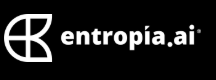

### Entropía AI Candidates Test  
Data Scientist Test: Time Series Forecasting  
**Miguel Ángel Zamorano Presa**

### Section 1: Theory
 **1. Name two advantages and two disadvantages of using LSTM over ARIMA for time
 series forecasting.**  
Disadvantages:  
1. LSTM architecture is Black box model ,that means that its hard to  attribute predictions to specific factors or patterns 
2. Computational complexity:Training LSTM architectures are computationally intensive and often requires GPU, finetunning hyperparameters are necesarry for minimize vanish gradient and overfitting.

Advantages:  
1. LSTM is able to learn non linear patterns,less sensitive to non stationarity, heavy tailed distributions,shift distributions, in comparison to ARIMA models but also we still need to take care for scale,missing values and noisy data,those factors will result in spurious predictions  
2. LSTM introduces memory cells and gating mechanism to selectively retain or discard info over secuences adressing the vanishing gradient problem of RNN enabling long term learning. 

 **2. Why is standard k-fold cross-validation not suitable for time series data? What tech
nique would you recommend instead?**  


Cross validating in TS is tricky, you can't use traditional K fold because you will end up training on  future samples,instead you can use timeseries split of sklearn, in which each fold the training indices will always come before before the test indices

### Section 2: Case Study

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults, ARIMAResultsWrapper
import matplotlib.pyplot as plt
import plotly.express as px
from prophet import Prophet
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json


###  Index
1. Results Catalog 
2. Data Cleanning
3. Models:
    1. Baseline Model(Arima)
    2. LSTM
    3. Prophet
    4. Metrics and report results
### apendix
1. EDA Results






### Results Catalog

### Data Cleanning  

**1st DataSet Version**
1. Drop rows with Ventas = 0
2. duplicate treatment
3. Outliers treatment ->Log Normalization
4. Daily,weekly,Montly sells agregate
5. add new columns
    1. Split and add date columns


### Data cleanning & EDA

/tmp/ipykernel_227838/816082017.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['Fecha', 'Estado'], as_index=False)['Ventas'].sum()
/tmp/ipykernel_227838/816082017.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_w = df_w.groupby(['Fecha', 'Estado'], as_index=False)['Ventas'].sum()
/tmp/ipykernel_227838/816082017.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_m = df_m.groupby(['Fecha

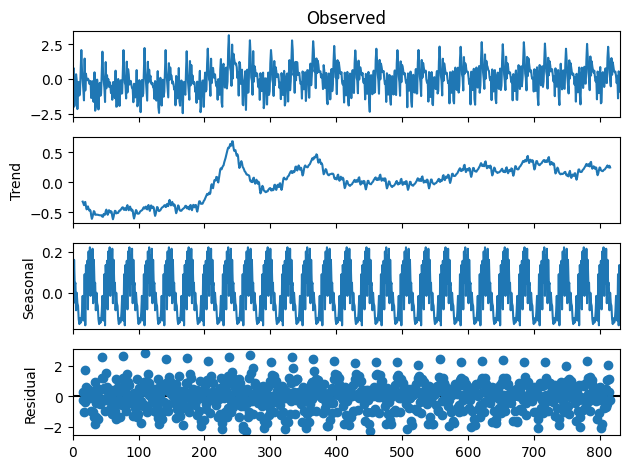

In [ ]:
base_dir = Path().resolve()/'Ventas_.csv'
df = pd.read_csv(base_dir,index_col=None, parse_dates=['Fecha'] )
df['Estado'] = df['Estado'].astype('category')
df = df.sort_values(by=['Fecha','Estado','Ventas'])


'''df = pd.concat([
    df[df['Ventas'] != 0],
    df[df['Ventas'] == 0].drop_duplicates()
], ignore_index=True)'''
# agregado_por_dia_estado
df['Fecha'] = df['Fecha'].dt.to_period('D').dt.start_time
df = df.groupby(['Fecha', 'Estado'], as_index=False)['Ventas'].sum()
df['Ventas'] = df['Ventas'].round(4)
#agregado por semana
# Agregado por semana sin sobrescribir el DataFrame principal
df_w = df.copy()
df_w['Fecha'] = df_w['Fecha'].dt.to_period('W').dt.start_time
df_w = df_w.groupby(['Fecha', 'Estado'], as_index=False)['Ventas'].sum()
#agregado por mes
df_m = df.copy()
df_m['Fecha'] = df_m['Fecha'].dt.to_period('M').dt.start_time
df_m = df_m.groupby(['Fecha', 'Estado'], as_index=False)['Ventas'].sum()

df1 = df.copy()

pt = PowerTransformer()
pv = pt.fit_transform(df['Ventas'].values.reshape(-1, 1))
df1['Ventas'] = pv.flatten()

df1['año'] = df['Fecha'].dt.year
df1['mes'] = df['Fecha'].dt.month
df1['trimestre'] = df['Fecha'].dt.quarter
df1['día'] = df['Fecha'].dt.day
df1['semana_dia'] = df['Fecha'].dt.dayofweek + 1  # Convert to 1-7 range
df1['semana'] = df['Fecha'].dt.isocalendar().week
df1.to_csv('Ventas_c_.csv', index=False)



ts_decompose = seasonal_decompose(df1['Ventas'].values, model='additive', period=30)
seasonal_component = ts_decompose.seasonal

# Visualize the decomposition
ts_decompose.plot()
plt.show()

In [14]:
print(df.info())
print('----------------------------------------------------------')
print(df.describe())
print('----------------------------------------------------------')
print(f'duplicated rows:  {df.duplicated().sum()}' )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   832 non-null    datetime64[ns]
 1   Estado  832 non-null    category      
 2   Ventas  832 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 15.2 KB
None
----------------------------------------------------------
                               Fecha        Ventas
count                            832  8.320000e+02
mean   2024-03-16 17:32:18.461538560  4.631534e+06
min              2023-03-01 00:00:00  4.106204e+04
25%              2023-09-01 00:00:00  5.596225e+05
50%              2024-03-16 12:00:00  1.610339e+06
75%              2024-10-01 00:00:00  3.480567e+06
max              2025-04-01 00:00:00  1.712746e+08
std                              NaN  1.165083e+07
----------------------------------------------------------
duplicated rows:  0


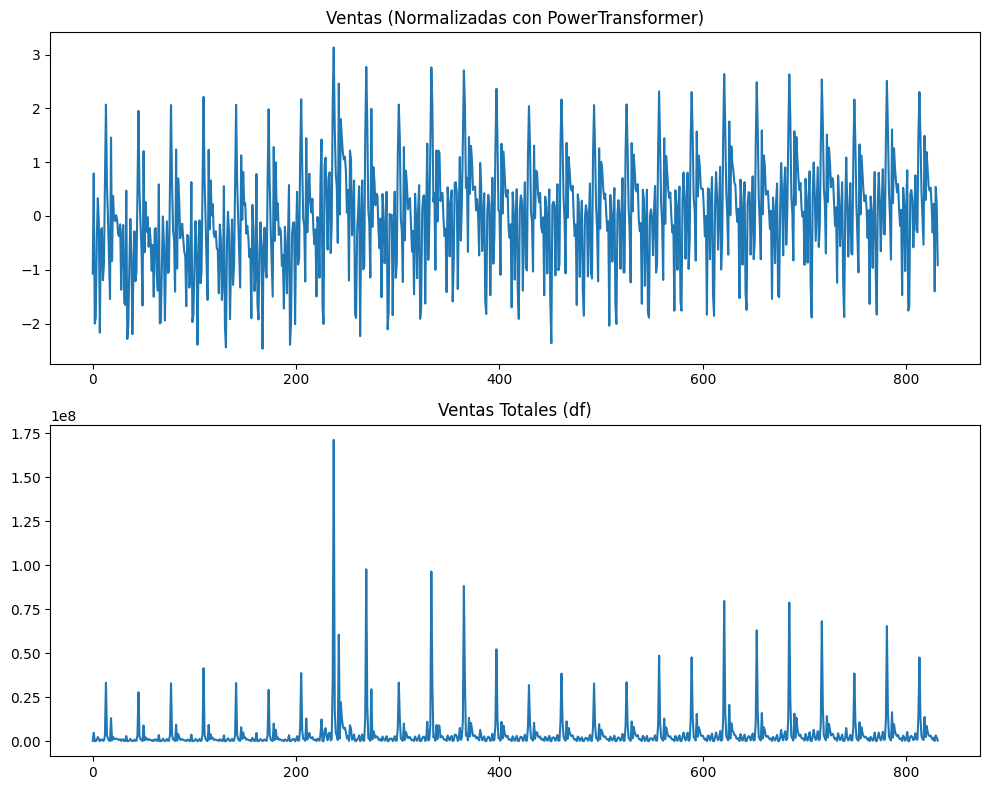

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

df1['Ventas'].plot(ax=axes[0], title='Ventas (Normalizadas con PowerTransformer)')
df['Ventas'].plot(ax=axes[1], title='Ventas Totales (df)')

plt.tight_layout()
plt.show()

In [ ]:
from plotly.subplots import make_subplots

edos = df.Estado.unique()
fig = make_subplots(rows=1, cols=2, subplot_titles=("Datos Ventas Originales", "Datos Ventas Log Normalizados"))

# Gráfica para df
for edo in edos:
    df_edo = df[df['Estado'] == edo]
    fig.add_scatter(x=df_edo['Fecha'], y=df_edo['Ventas'], mode='lines', name=edo, legendgroup=edo, showlegend=(True if edo == edos[0] else False), row=1, col=1)

# Gráfica para df1
for edo in edos:
    df_edo = df1[df1['Estado'] == edo]
    fig.add_scatter(x=df_edo['Fecha'], y=df_edo['Ventas'], mode='lines', name=edo, legendgroup=edo, showlegend=False, row=1, col=2)

fig.update_layout(height=500, width=1200, title_text="Ventas por Estado Normalizadas y Originales",
                  xaxis_title='Fecha', yaxis_title='Ventas',
                  xaxis2_title='Fecha', yaxis2_title='Ventas')
#fig.update_xaxes(matches='x')
#fig.update_yaxes(matches='y')
fig.update_layout(legend_title_text='Estado')
fig.update_layout(legend=dict(x=0.5, y=1.1, orientation='h', xanchor='center'))
fig.update_layout(template='plotly_white')
fig.show()


<Axes: title={'center': 'Ventas in Jalisco'}, xlabel='Fecha'>

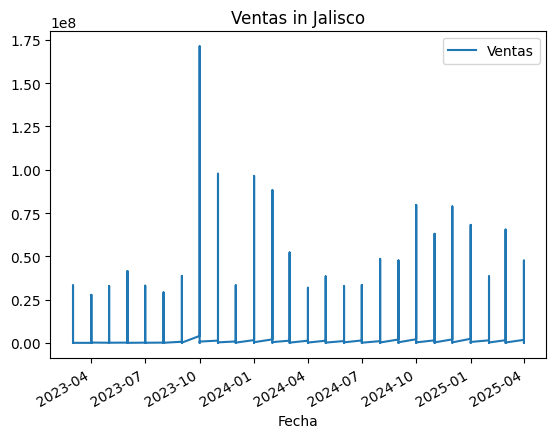

In [ ]:
df.plot(x='Fecha', y='Ventas', kind='line', title='Ventas in Jalisco')

In [19]:
df1.columns

Index(['Fecha', 'Estado', 'Ventas', 'año', 'mes', 'trimestre', 'día',
       'semana_dia', 'semana'],
      dtype='object')

### Model fitting Prophet

In [30]:
edos = df1.Estado.unique()
model_config = {
        'yearly_seasonality': 'auto', 
        'weekly_seasonality': 'auto',
        'daily_seasonality': False,
        'seasonality_mode': 'multiplicative',  # Cambiado a multiplicativo
        'seasonality_prior_scale': 0.1,  # Reduce la flexibilidad
        'holidays_prior_scale': 0.1,
        'changepoint_prior_scale': 0.001,  # Muy conservador para tendencias
        'changepoint_range': 0.8,
        'interval_width': 0.8
    }

00:41:03 - cmdstanpy - INFO - Chain [1] start processing
00:41:03 - cmdstanpy - INFO - Chain [1] done processing
00:41:03 - cmdstanpy - INFO - Chain [1] start processing
00:41:03 - cmdstanpy - INFO - Chain [1] done processing
00:41:03 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.04', '0.07']
R² por fold: ['-1.464', '-5.277']
MAE por fold: ['0.18', '0.24']


00:41:03 - cmdstanpy - INFO - Chain [1] done processing


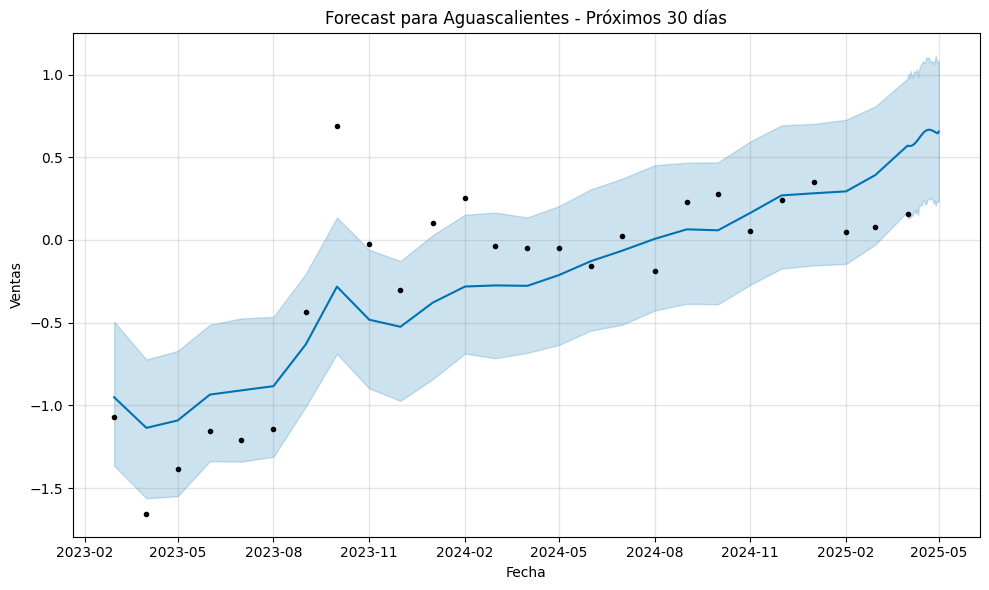

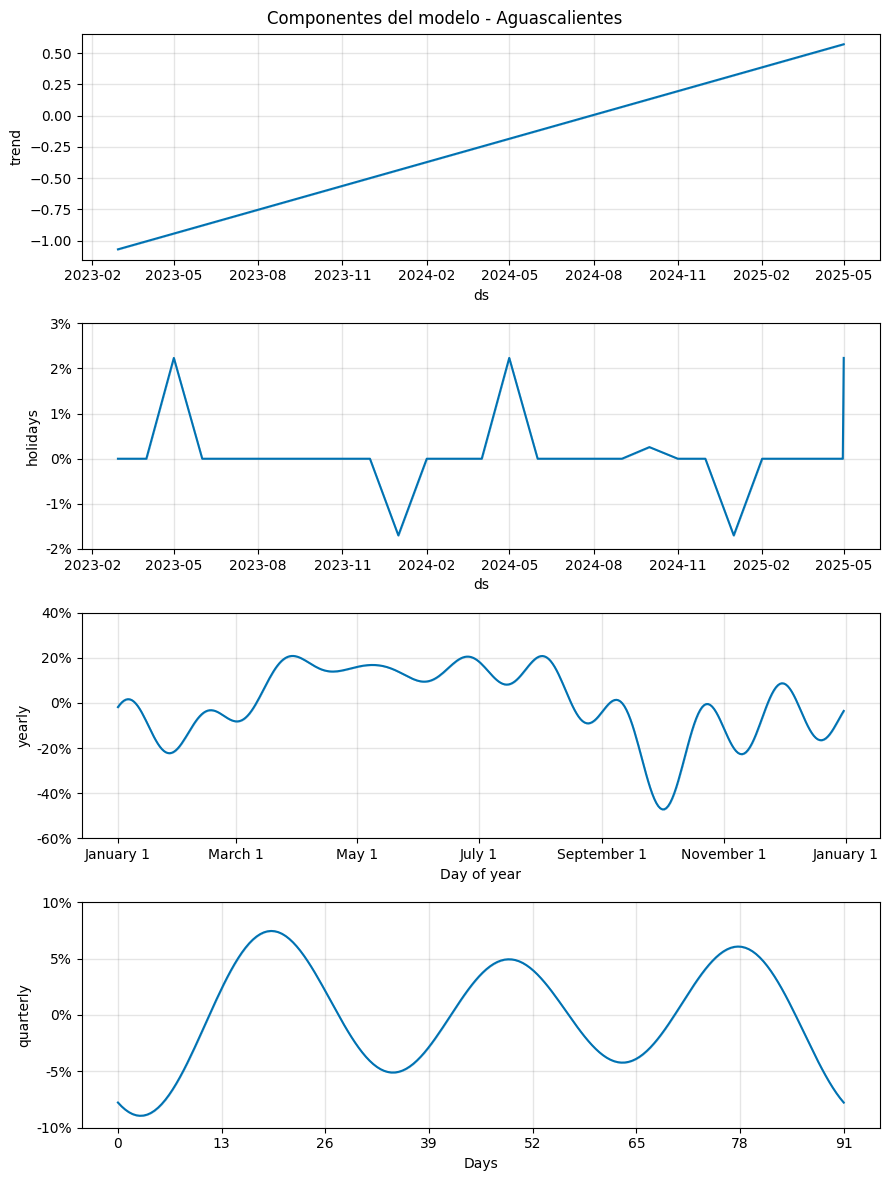

00:41:05 - cmdstanpy - INFO - Chain [1] start processing
00:41:05 - cmdstanpy - INFO - Chain [1] done processing
00:41:06 - cmdstanpy - INFO - Chain [1] start processing
00:41:06 - cmdstanpy - INFO - Chain [1] done processing
00:41:06 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.08', '0.07']
R² por fold: ['-11.089', '-5.097']
MAE por fold: ['0.27', '0.25']


00:41:06 - cmdstanpy - INFO - Chain [1] done processing


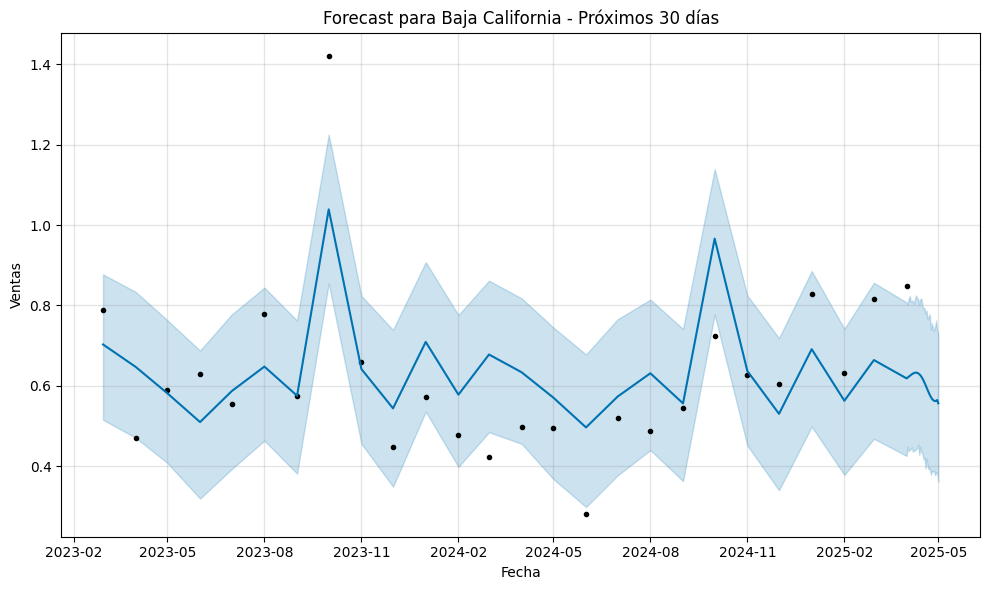

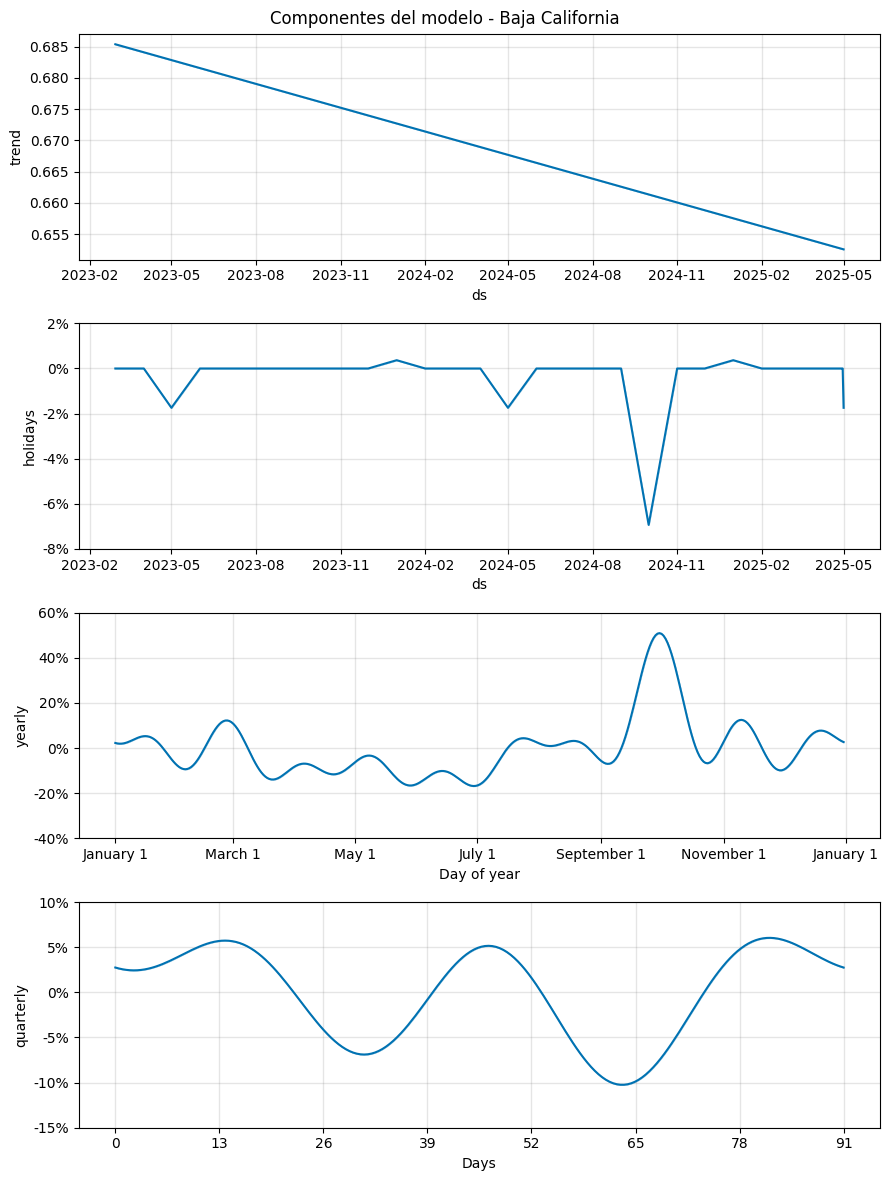

00:41:08 - cmdstanpy - INFO - Chain [1] start processing
00:41:08 - cmdstanpy - INFO - Chain [1] done processing
00:41:09 - cmdstanpy - INFO - Chain [1] start processing
00:41:09 - cmdstanpy - INFO - Chain [1] done processing
00:41:09 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.27', '0.06']
R² por fold: ['-9.018', '-0.401']
MAE por fold: ['0.49', '0.19']


00:41:09 - cmdstanpy - INFO - Chain [1] done processing


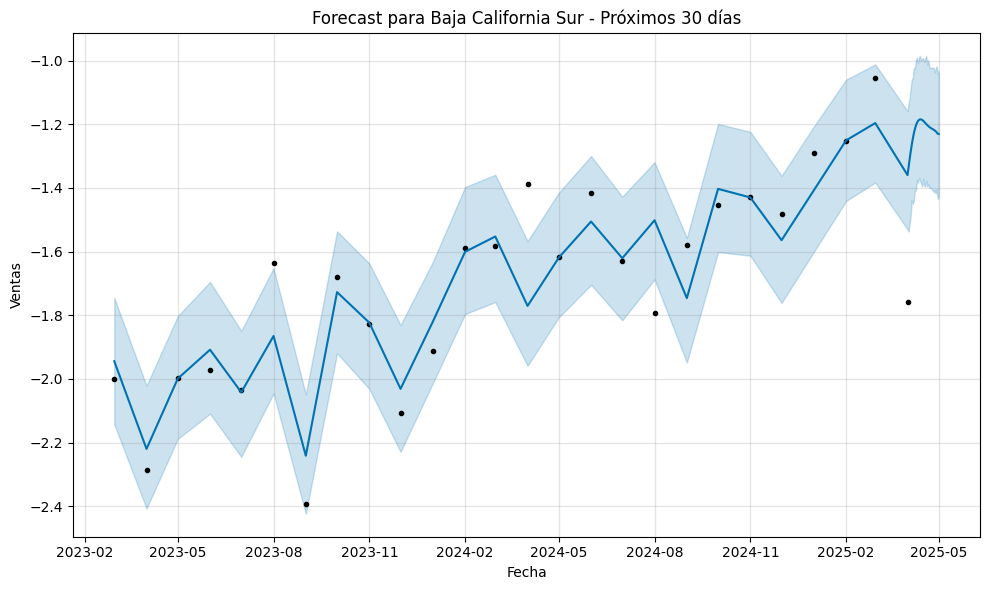

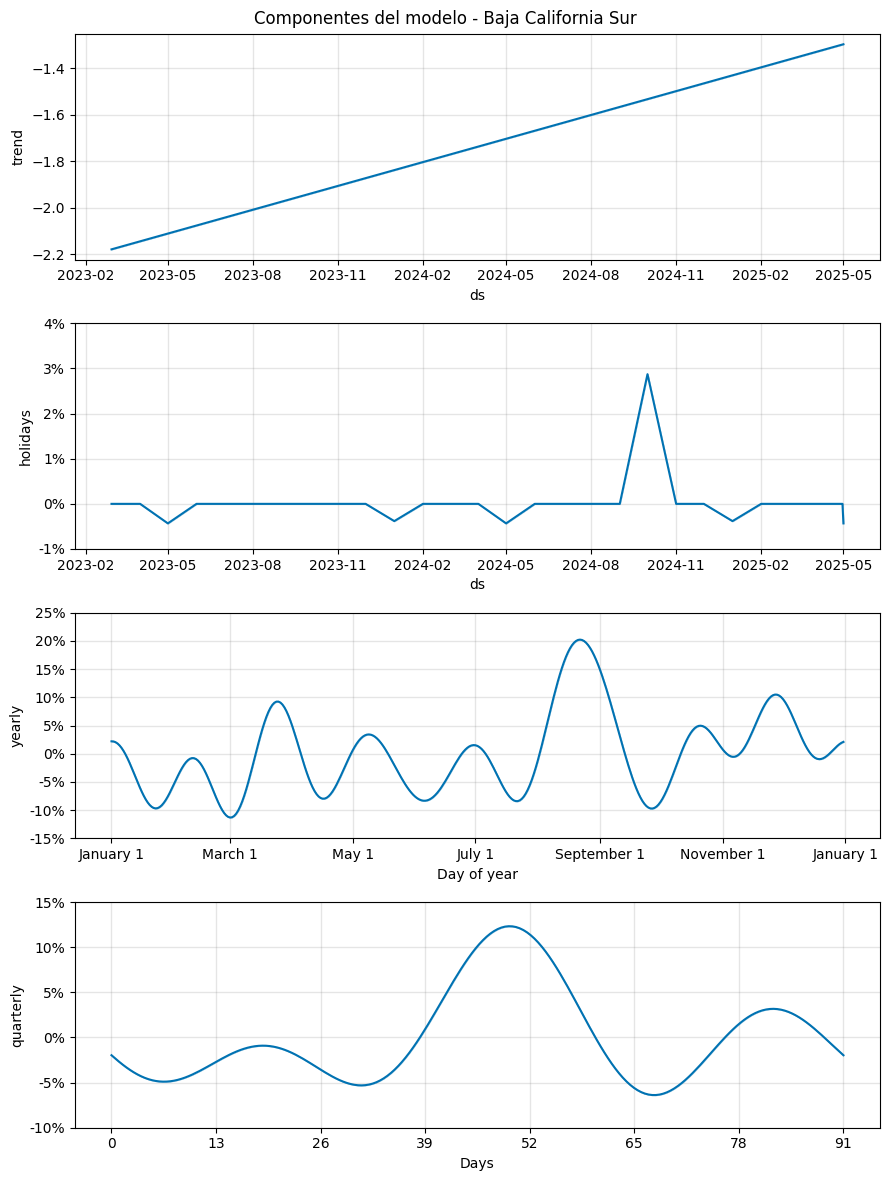

00:41:11 - cmdstanpy - INFO - Chain [1] start processing
00:41:11 - cmdstanpy - INFO - Chain [1] done processing
00:41:12 - cmdstanpy - INFO - Chain [1] start processing
00:41:12 - cmdstanpy - INFO - Chain [1] done processing
00:41:12 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.17', '0.03']
R² por fold: ['-0.058', '-1.324']
MAE por fold: ['0.27', '0.16']


00:41:13 - cmdstanpy - INFO - Chain [1] done processing


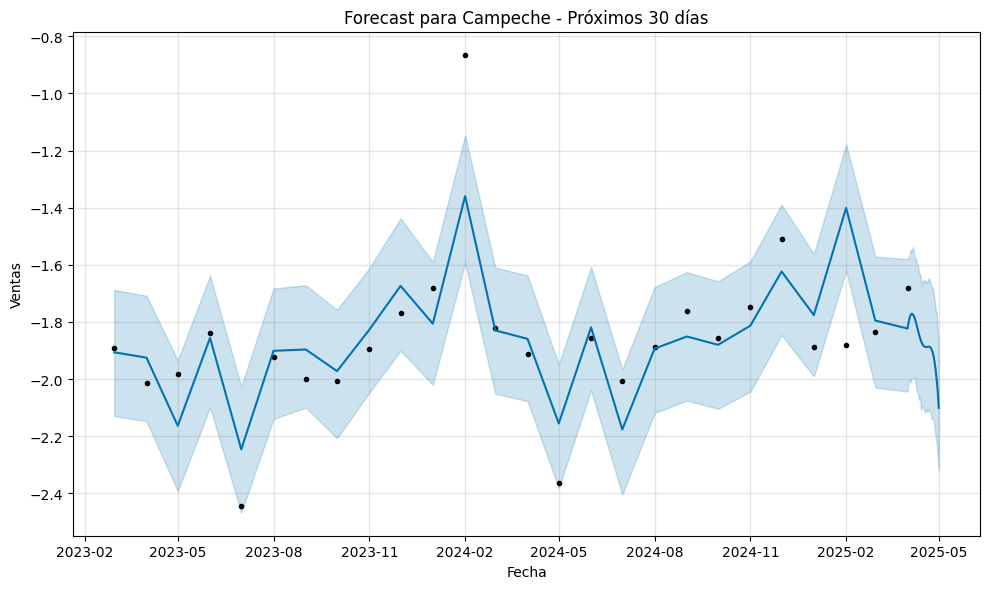

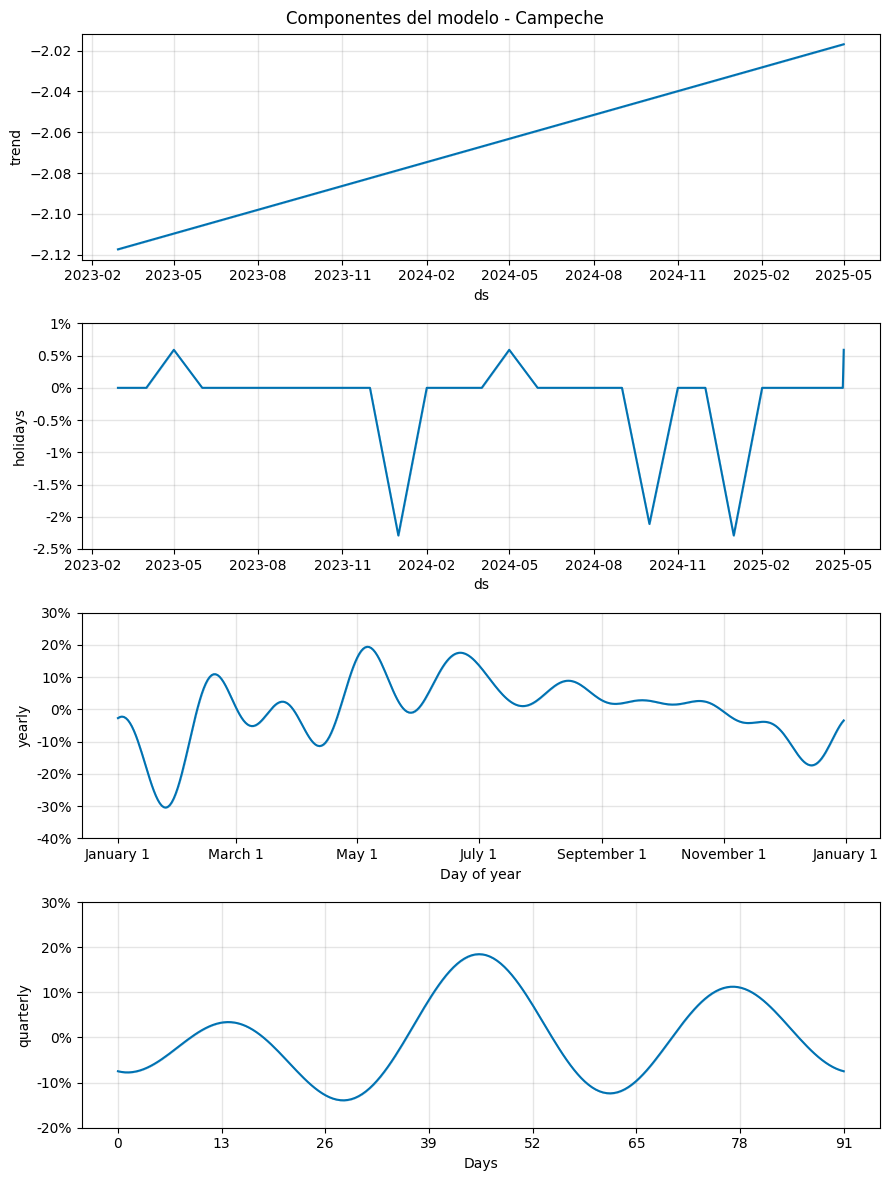

00:41:14 - cmdstanpy - INFO - Chain [1] start processing
00:41:16 - cmdstanpy - INFO - Chain [1] done processing
00:41:16 - cmdstanpy - INFO - Chain [1] start processing
00:41:18 - cmdstanpy - INFO - Chain [1] done processing
00:41:18 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.04', '0.08']
R² por fold: ['-0.072', '-6.035']
MAE por fold: ['0.15', '0.26']


00:41:36 - cmdstanpy - INFO - Chain [1] done processing


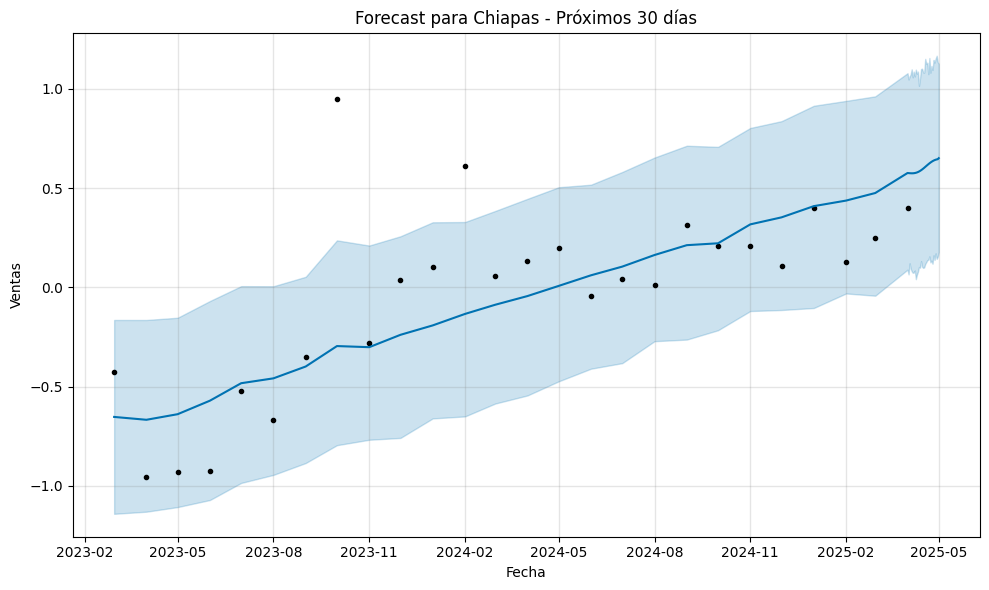

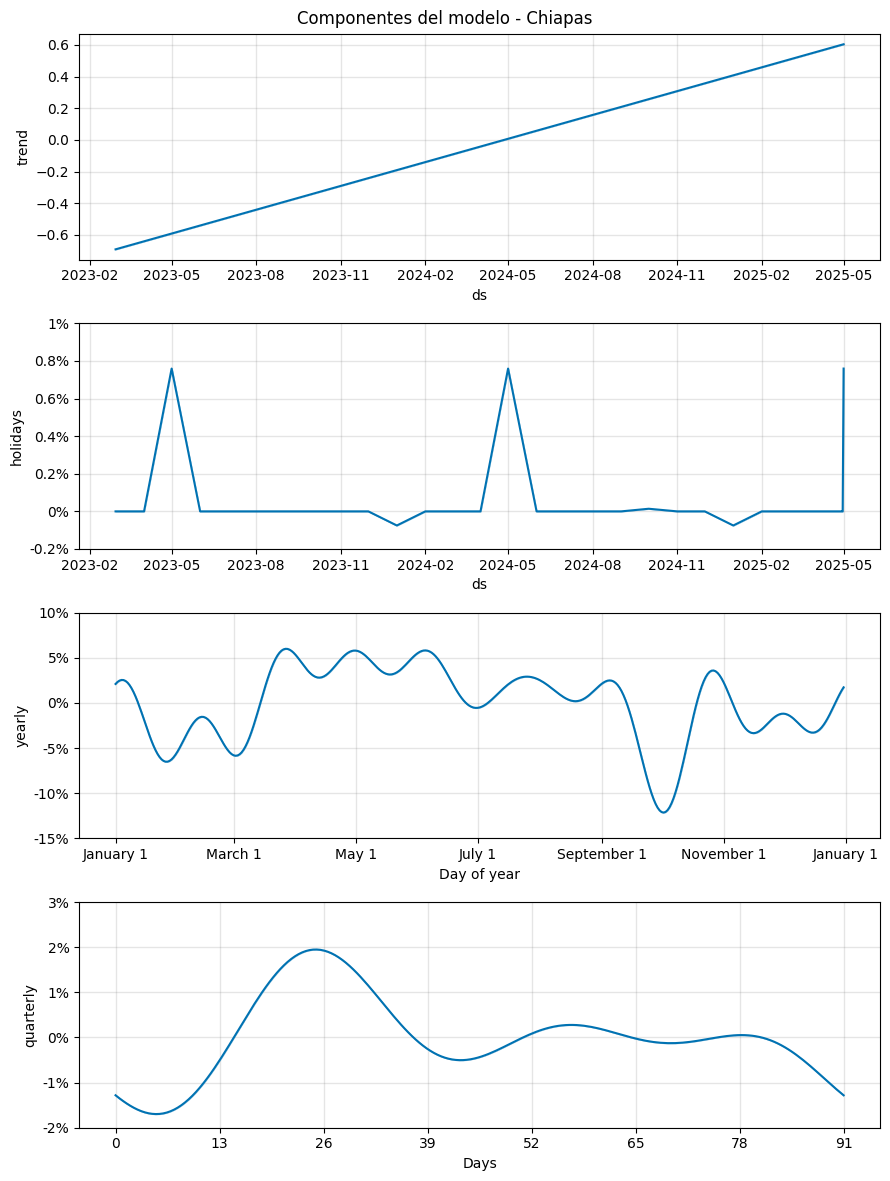

00:41:37 - cmdstanpy - INFO - Chain [1] start processing
00:41:37 - cmdstanpy - INFO - Chain [1] done processing
00:41:38 - cmdstanpy - INFO - Chain [1] start processing
00:41:38 - cmdstanpy - INFO - Chain [1] done processing
00:41:38 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.04', '0.24']
R² por fold: ['-0.828', '-3.947']
MAE por fold: ['0.15', '0.43']


00:41:38 - cmdstanpy - INFO - Chain [1] done processing


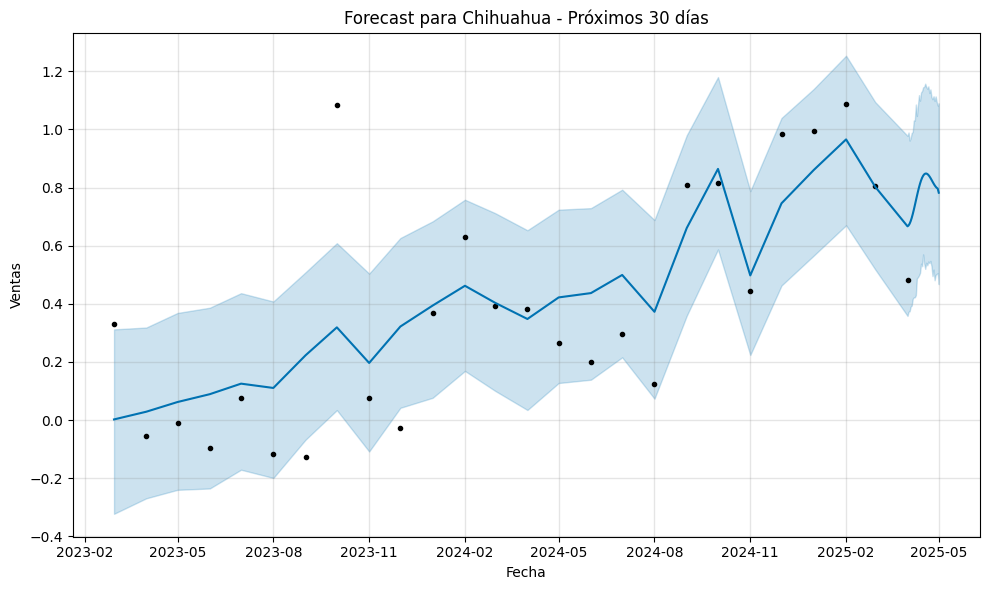

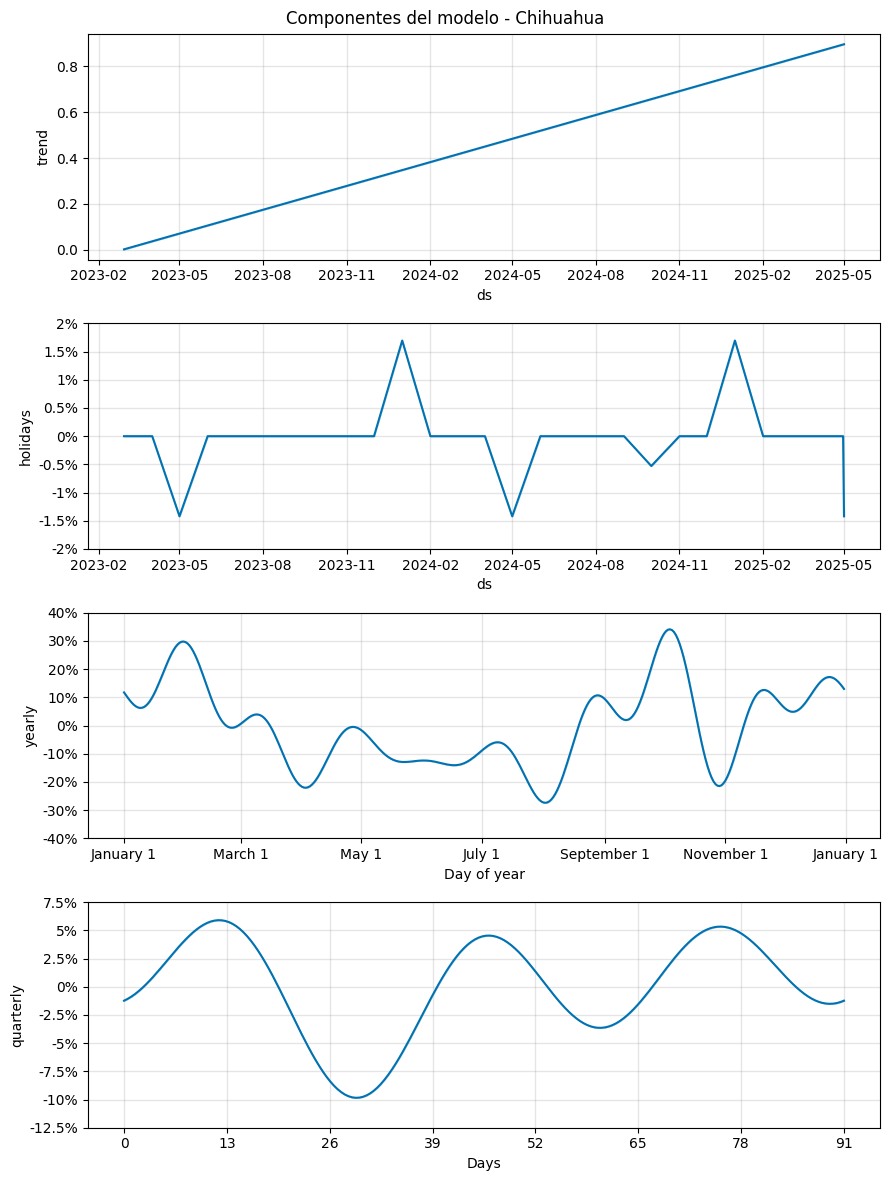

00:41:40 - cmdstanpy - INFO - Chain [1] start processing
00:41:40 - cmdstanpy - INFO - Chain [1] done processing
00:41:40 - cmdstanpy - INFO - Chain [1] start processing
00:41:41 - cmdstanpy - INFO - Chain [1] done processing
00:41:41 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.03', '0.01']
R² por fold: ['-0.246', '-0.260']
MAE por fold: ['0.15', '0.06']


00:41:42 - cmdstanpy - INFO - Chain [1] done processing


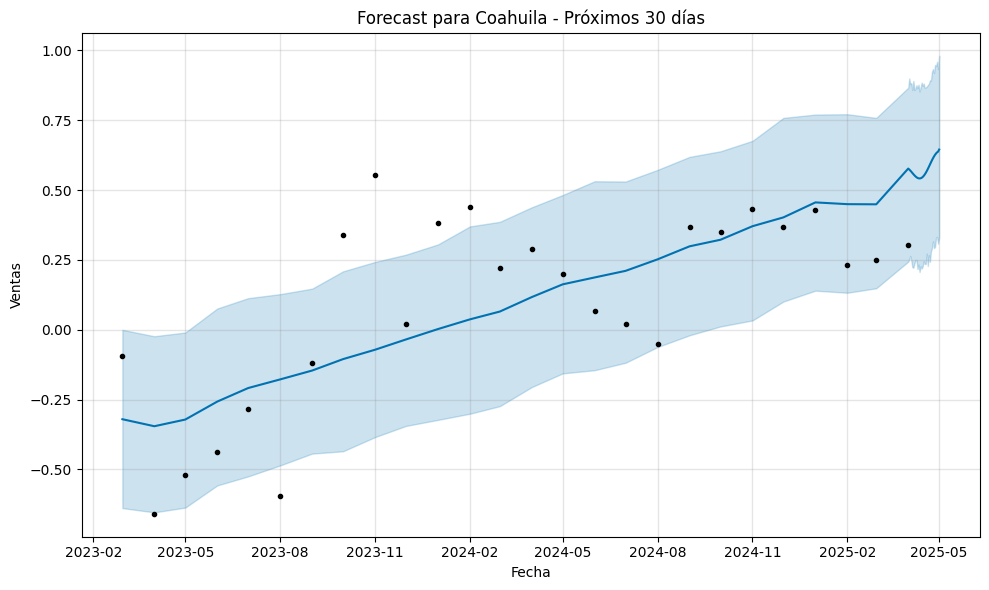

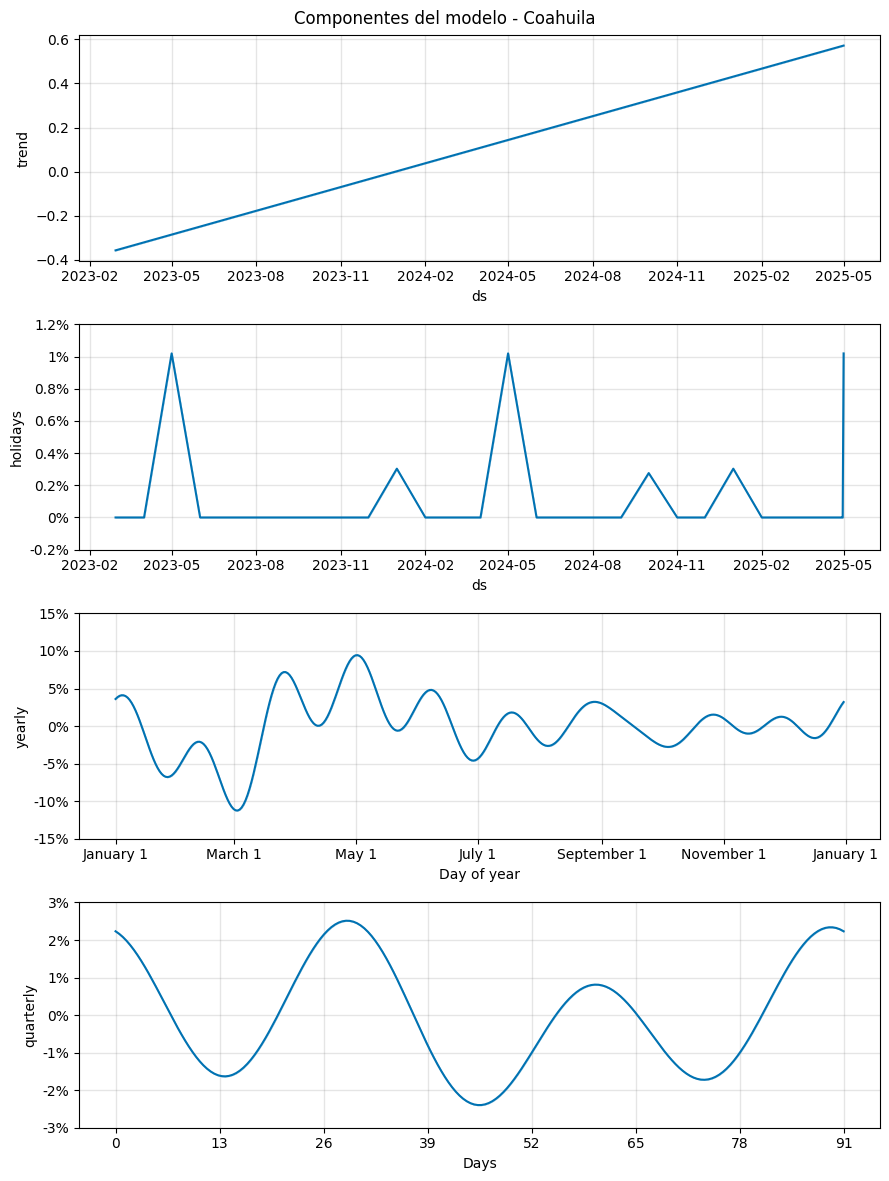

00:41:44 - cmdstanpy - INFO - Chain [1] start processing
00:41:44 - cmdstanpy - INFO - Chain [1] done processing
00:41:44 - cmdstanpy - INFO - Chain [1] start processing
00:41:46 - cmdstanpy - INFO - Chain [1] done processing
00:41:46 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.42', '0.10']
R² por fold: ['-4.618', '-8.353']
MAE por fold: ['0.58', '0.29']


00:41:47 - cmdstanpy - INFO - Chain [1] done processing


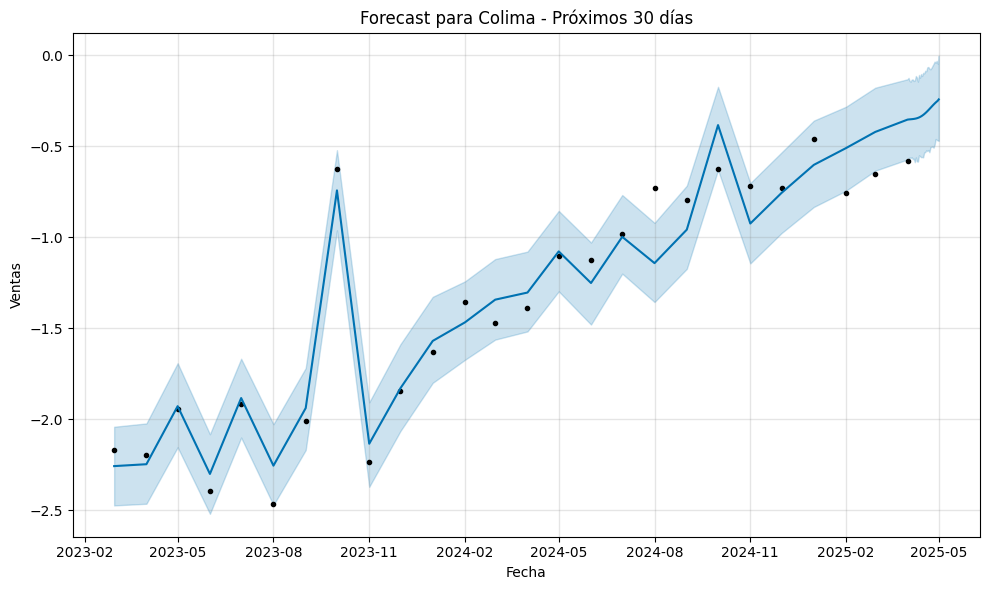

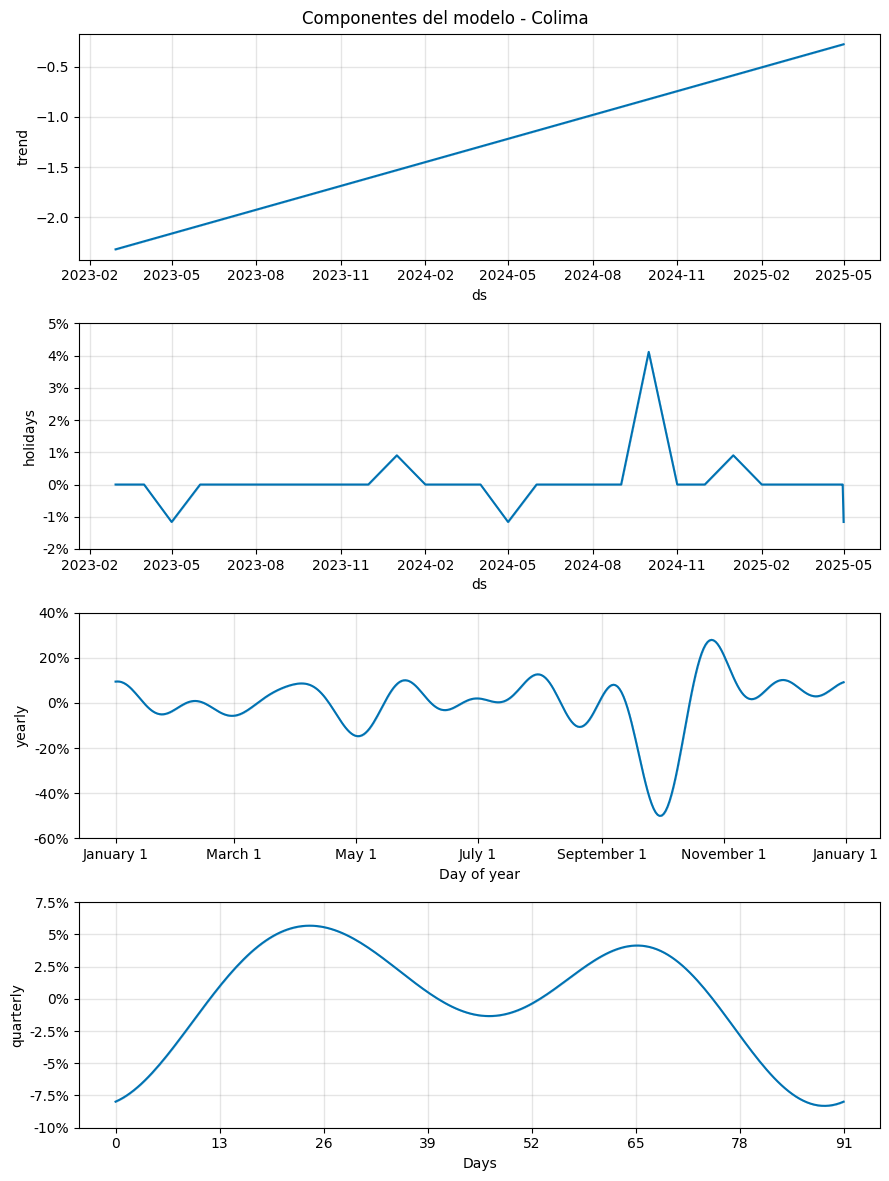

00:41:49 - cmdstanpy - INFO - Chain [1] start processing
00:41:49 - cmdstanpy - INFO - Chain [1] done processing
00:41:49 - cmdstanpy - INFO - Chain [1] start processing
00:41:50 - cmdstanpy - INFO - Chain [1] done processing
00:41:50 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.01', '0.03']
R² por fold: ['-0.037', '-0.223']
MAE por fold: ['0.06', '0.15']


00:41:50 - cmdstanpy - INFO - Chain [1] done processing


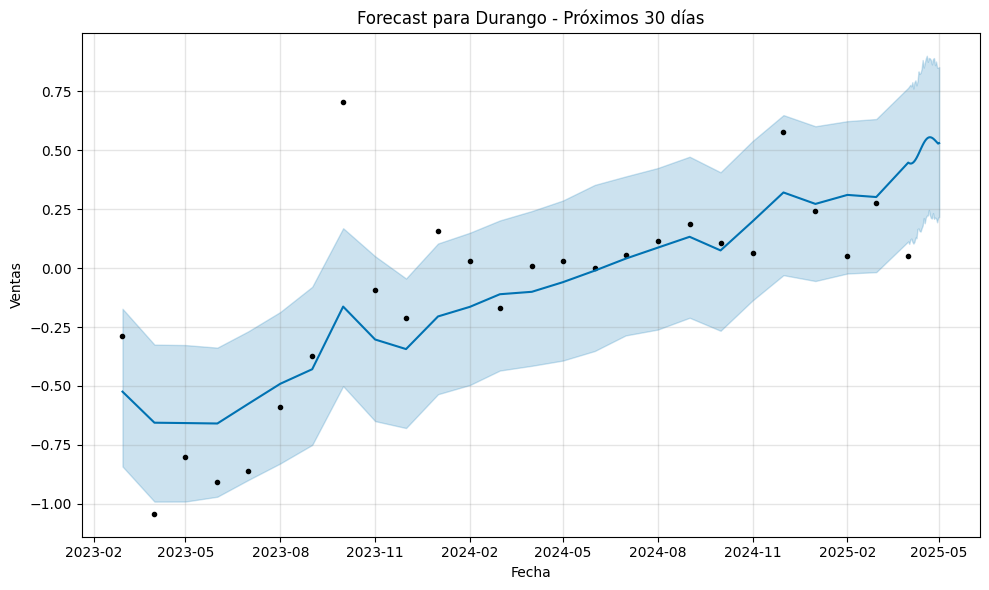

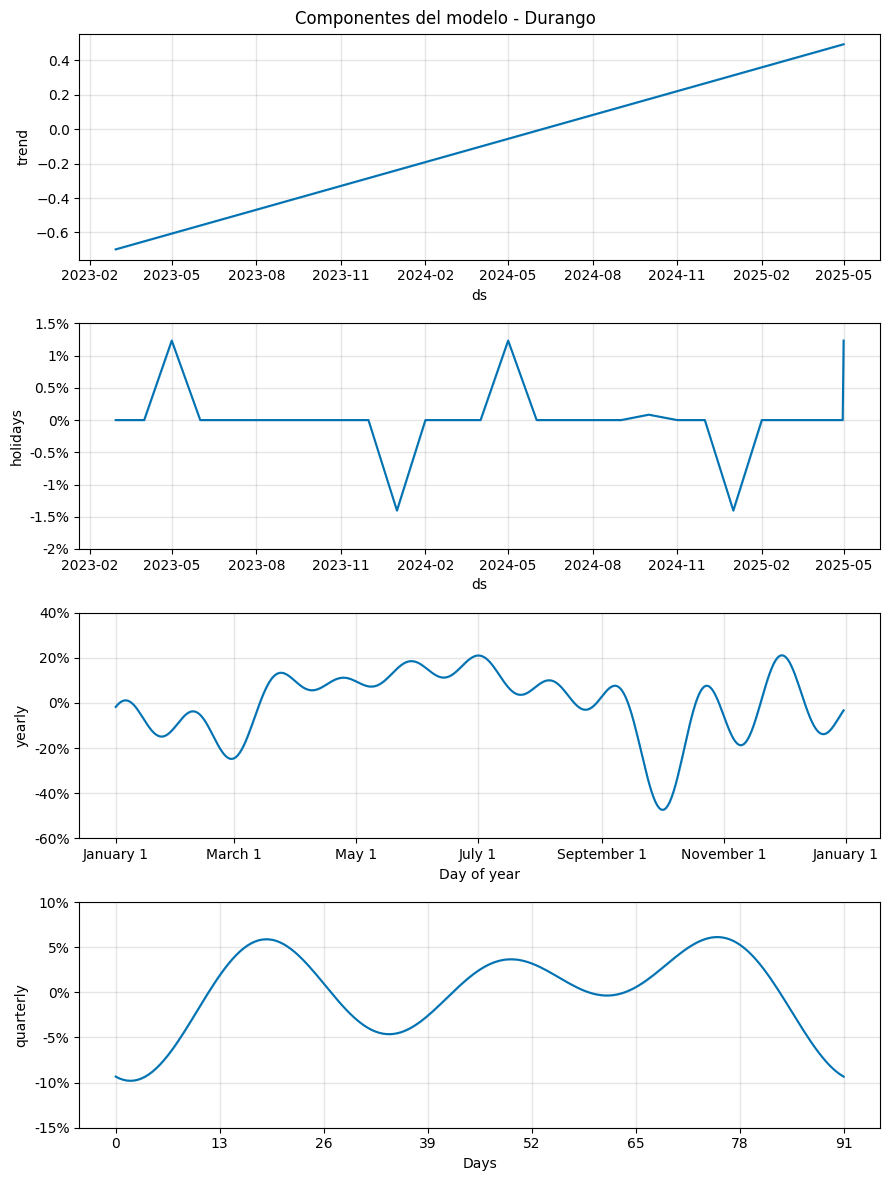

00:41:52 - cmdstanpy - INFO - Chain [1] start processing
00:41:52 - cmdstanpy - INFO - Chain [1] done processing
00:41:52 - cmdstanpy - INFO - Chain [1] start processing
00:41:53 - cmdstanpy - INFO - Chain [1] done processing
00:41:53 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.10', '0.01']
R² por fold: ['-0.336', '-0.180']
MAE por fold: ['0.19', '0.08']


00:41:54 - cmdstanpy - INFO - Chain [1] done processing


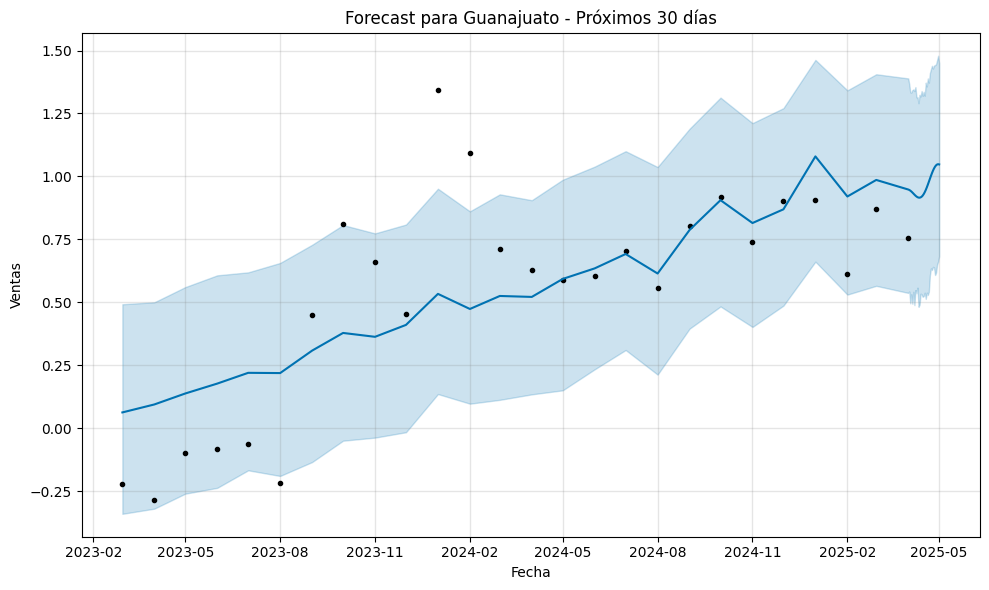

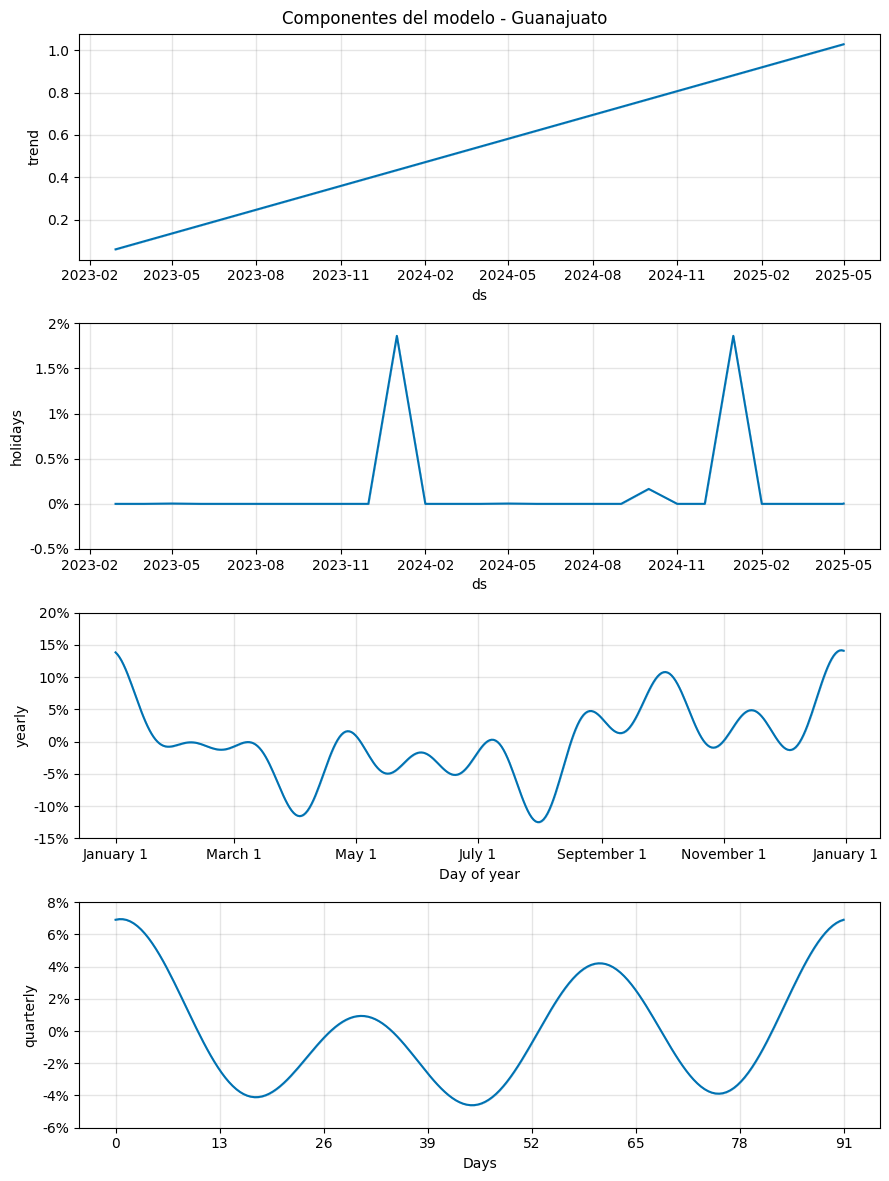

00:41:57 - cmdstanpy - INFO - Chain [1] start processing
00:41:57 - cmdstanpy - INFO - Chain [1] done processing
00:41:57 - cmdstanpy - INFO - Chain [1] start processing
00:41:57 - cmdstanpy - INFO - Chain [1] done processing
00:41:57 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.04', '0.09']
R² por fold: ['-0.118', '-0.387']
MAE por fold: ['0.14', '0.25']


00:41:58 - cmdstanpy - INFO - Chain [1] done processing


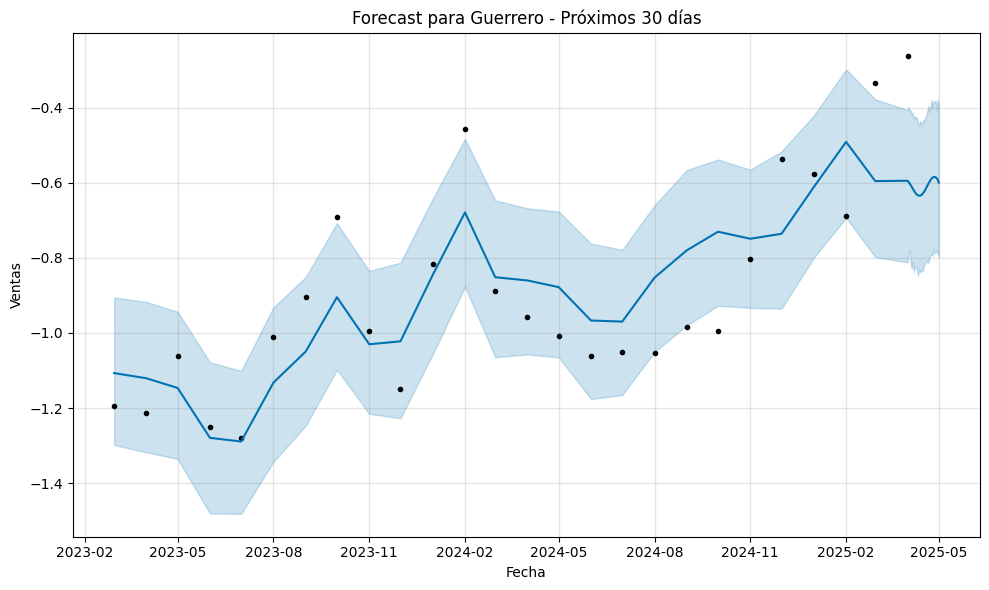

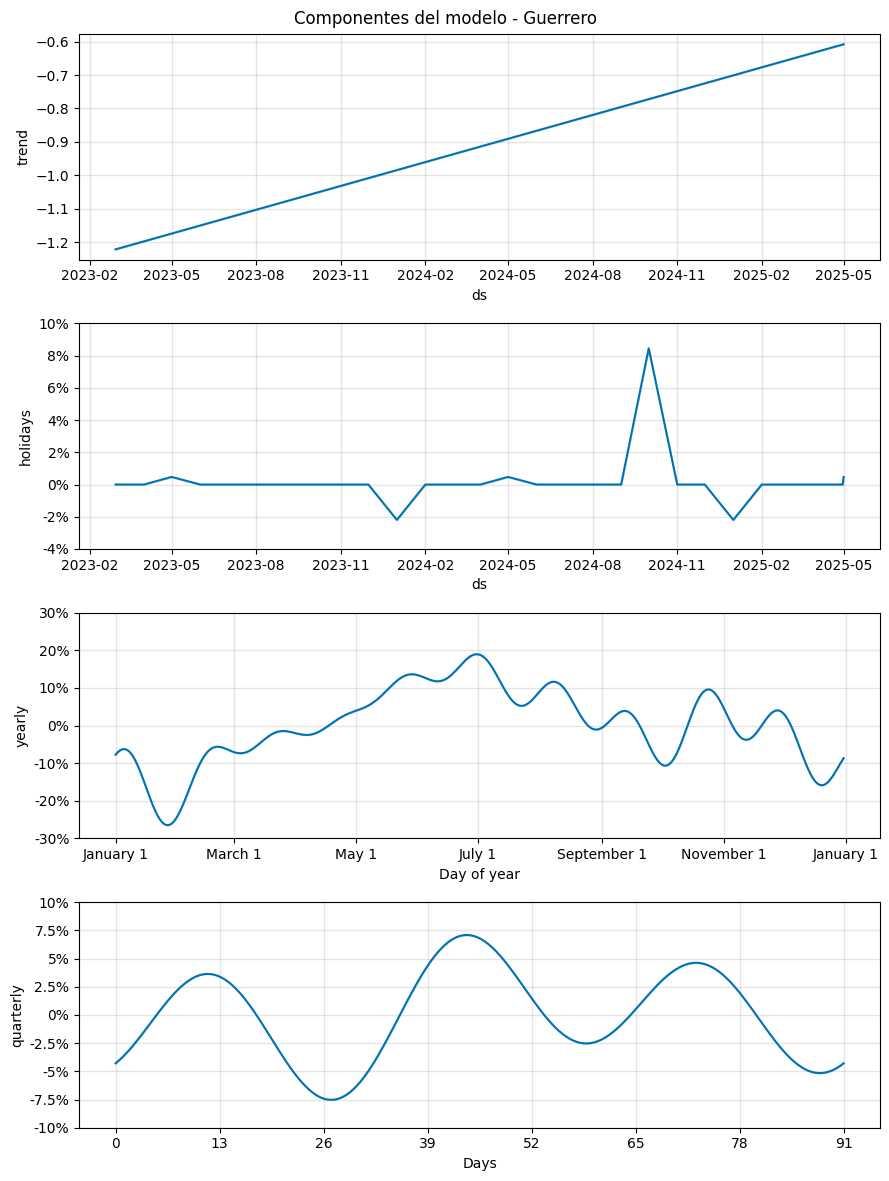

00:42:00 - cmdstanpy - INFO - Chain [1] start processing
00:42:02 - cmdstanpy - INFO - Chain [1] done processing
00:42:02 - cmdstanpy - INFO - Chain [1] start processing
00:42:04 - cmdstanpy - INFO - Chain [1] done processing
00:42:04 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.22', '0.10']
R² por fold: ['-0.007', '-1.331']
MAE por fold: ['0.39', '0.27']


00:42:06 - cmdstanpy - INFO - Chain [1] done processing


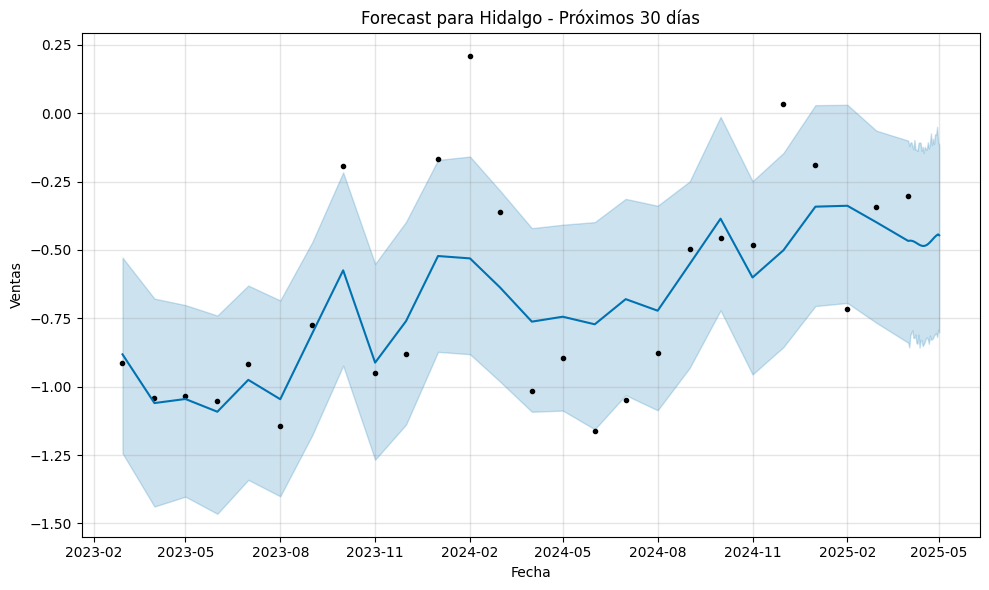

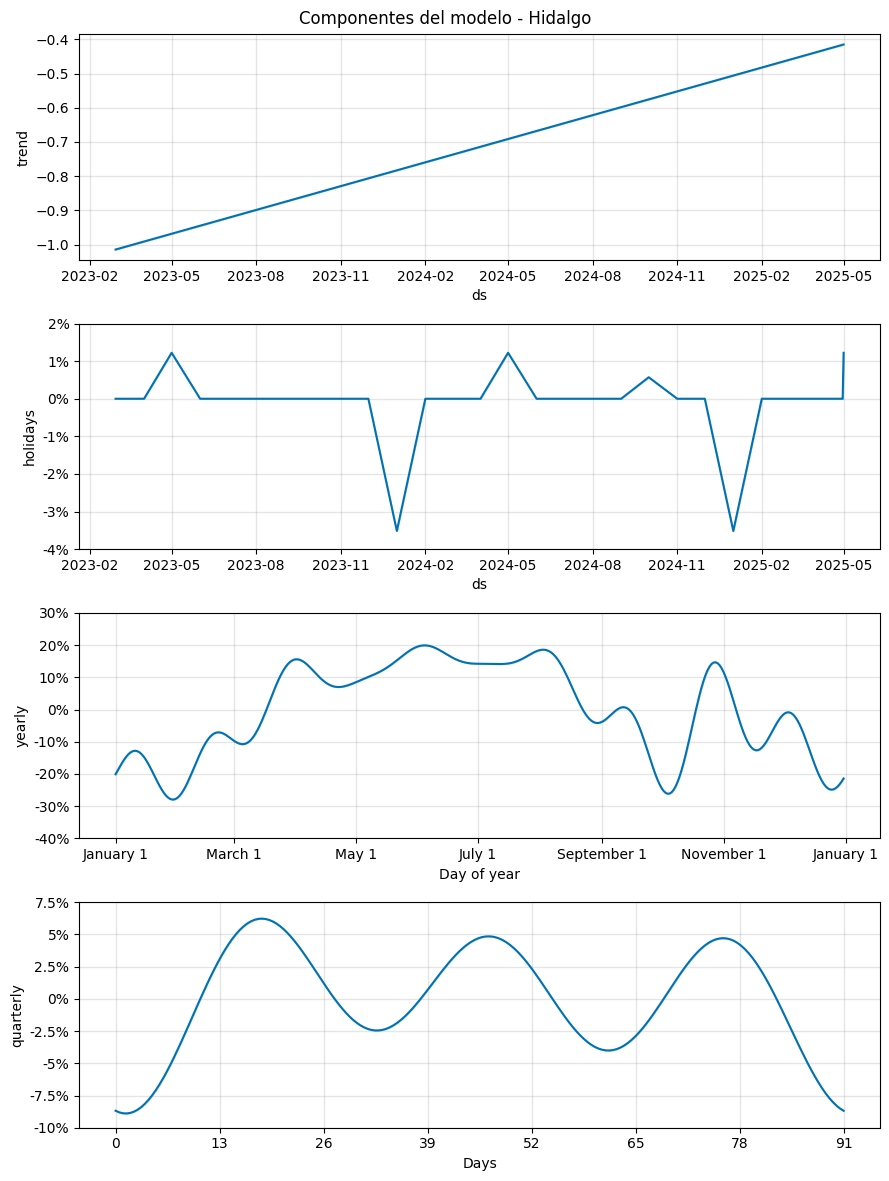

00:42:08 - cmdstanpy - INFO - Chain [1] start processing
00:42:08 - cmdstanpy - INFO - Chain [1] done processing
00:42:08 - cmdstanpy - INFO - Chain [1] start processing
00:42:08 - cmdstanpy - INFO - Chain [1] done processing


MSE por fold: ['0.05', '0.02']
R² por fold: ['-6.122', '-0.626']
MAE por fold: ['0.21', '0.10']


00:42:09 - cmdstanpy - INFO - Chain [1] start processing
00:42:09 - cmdstanpy - INFO - Chain [1] done processing


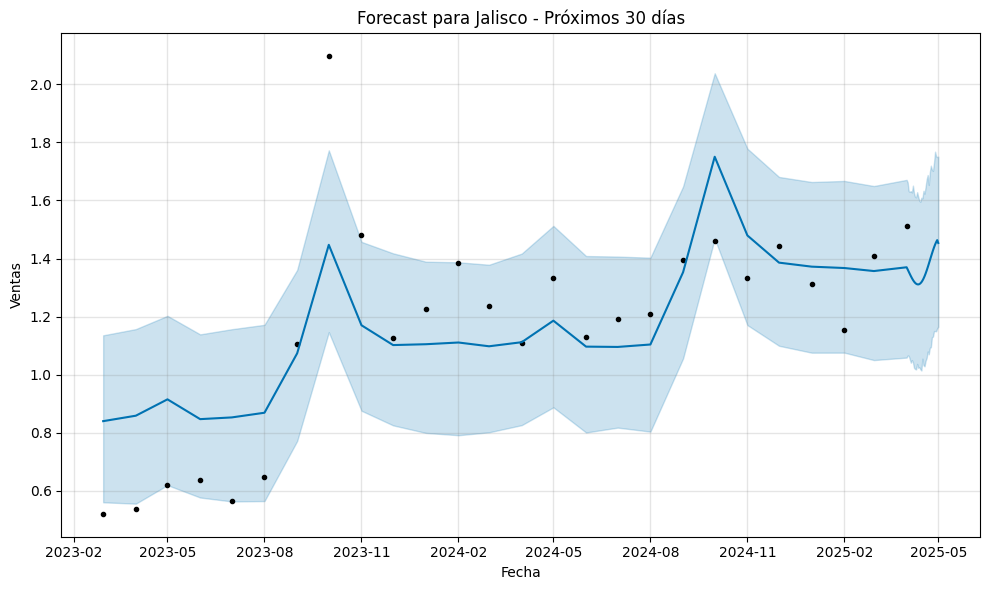

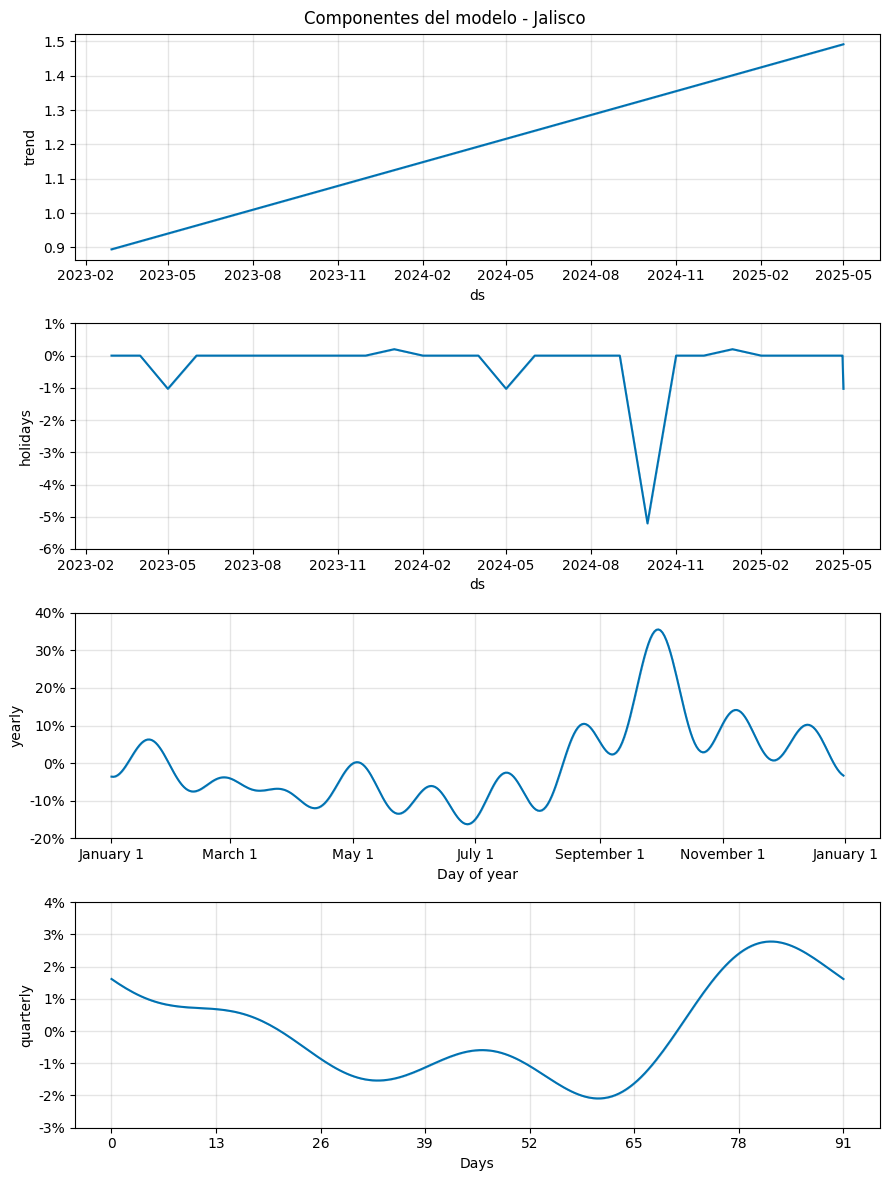

00:42:12 - cmdstanpy - INFO - Chain [1] start processing
00:42:12 - cmdstanpy - INFO - Chain [1] done processing
00:42:13 - cmdstanpy - INFO - Chain [1] start processing
00:42:13 - cmdstanpy - INFO - Chain [1] done processing
00:42:13 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.08', '0.04']
R² por fold: ['-0.179', '-0.692']
MAE por fold: ['0.26', '0.16']


00:42:13 - cmdstanpy - INFO - Chain [1] done processing


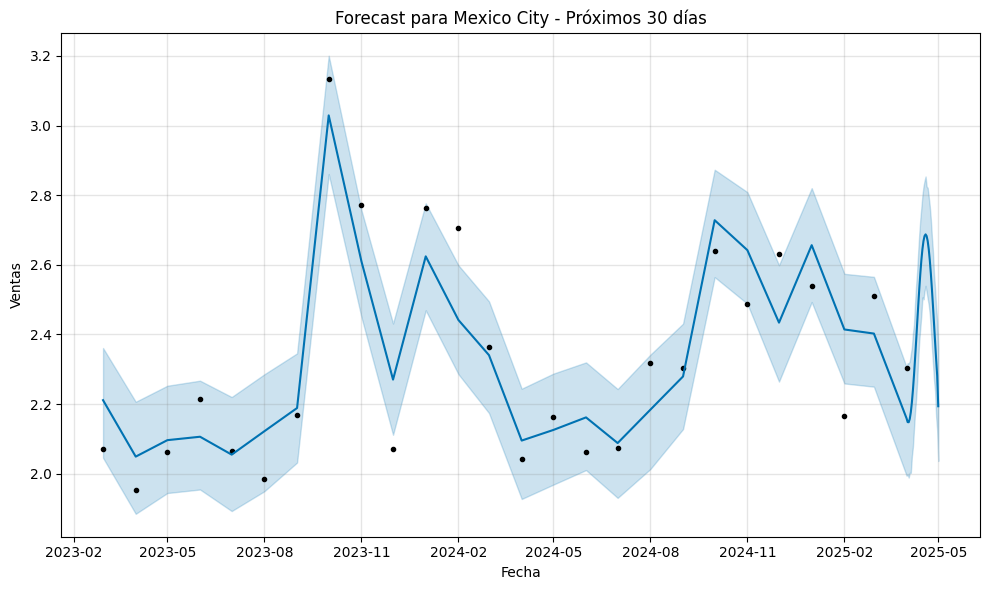

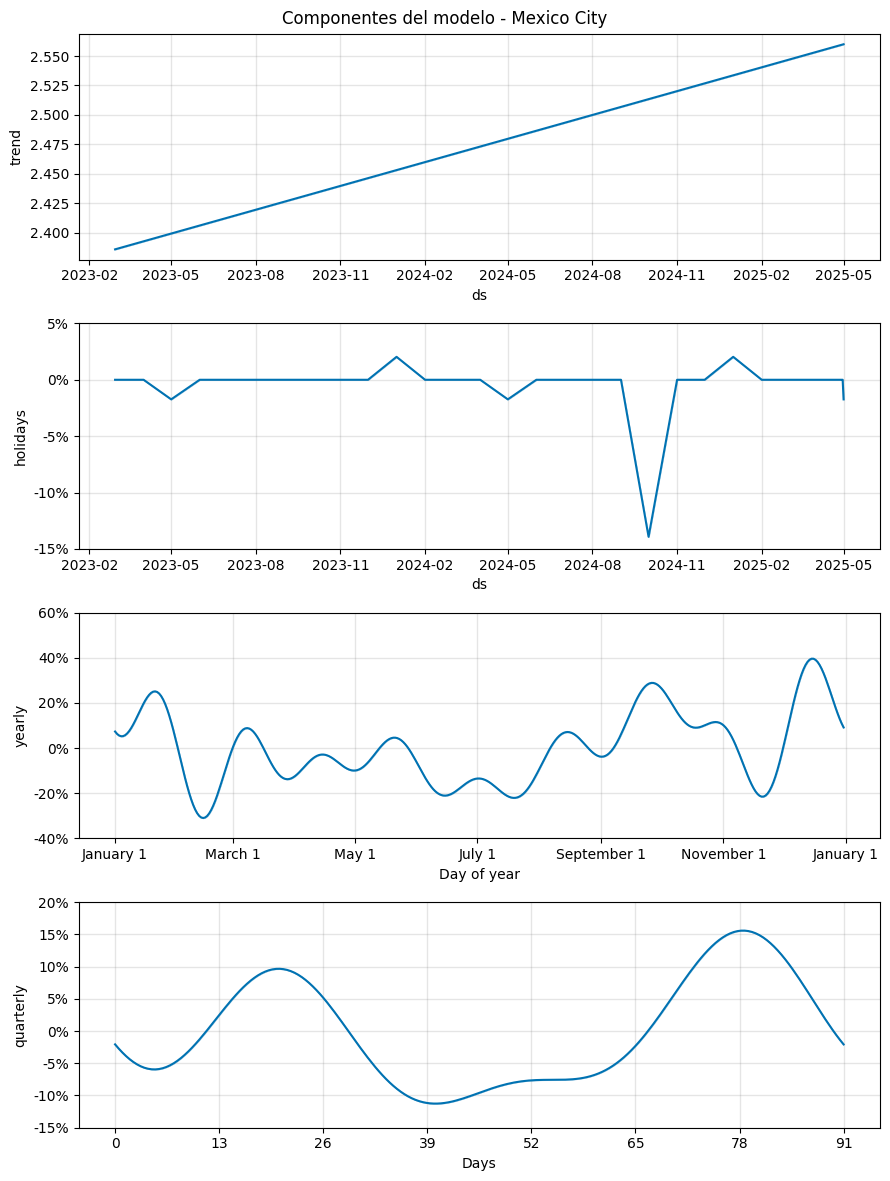

00:42:15 - cmdstanpy - INFO - Chain [1] start processing
00:42:17 - cmdstanpy - INFO - Chain [1] done processing
00:42:17 - cmdstanpy - INFO - Chain [1] start processing
00:42:19 - cmdstanpy - INFO - Chain [1] done processing
00:42:19 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.12', '0.04']
R² por fold: ['-0.063', '-0.746']
MAE por fold: ['0.25', '0.16']


00:42:21 - cmdstanpy - INFO - Chain [1] done processing


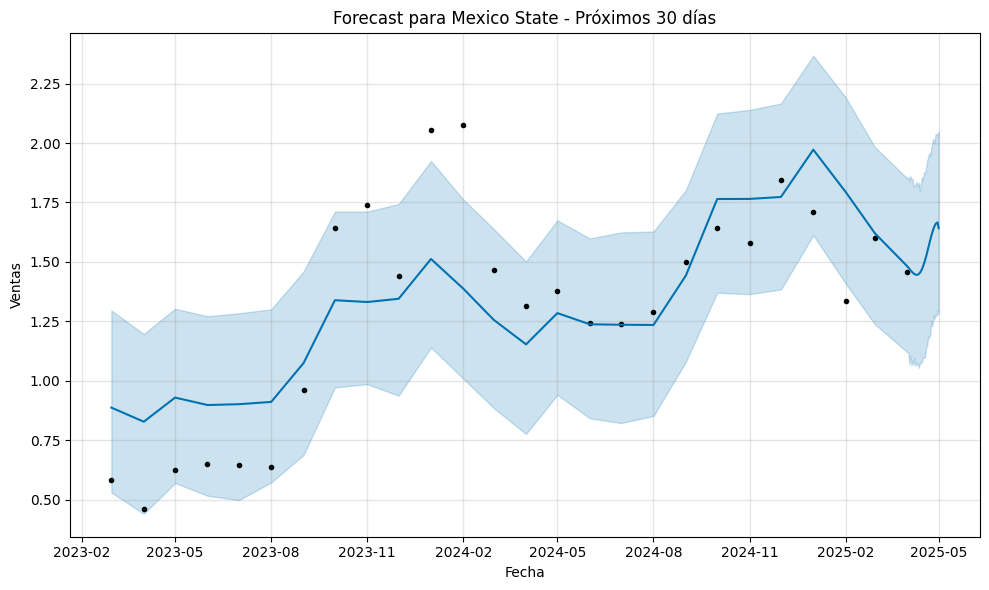

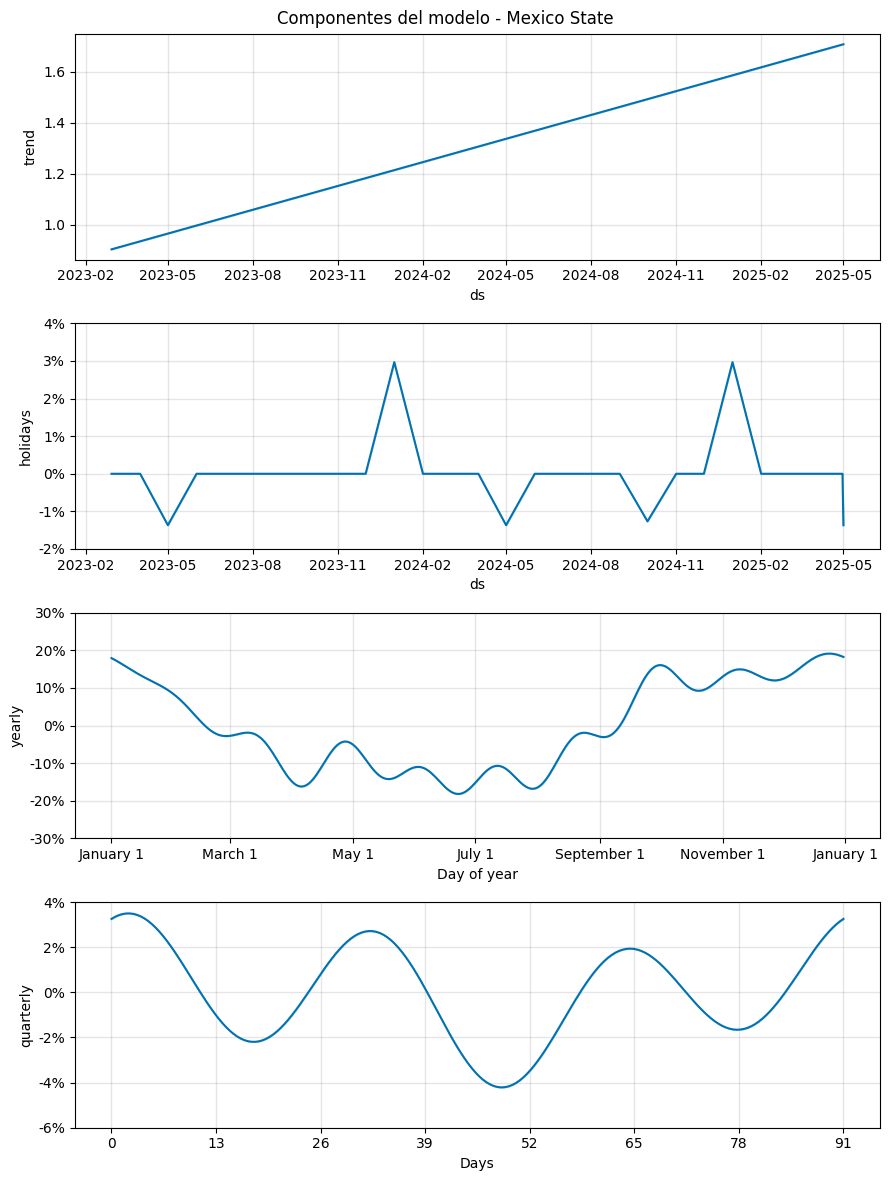

00:42:23 - cmdstanpy - INFO - Chain [1] start processing
00:42:23 - cmdstanpy - INFO - Chain [1] done processing
00:42:23 - cmdstanpy - INFO - Chain [1] start processing
00:42:24 - cmdstanpy - INFO - Chain [1] done processing
00:42:25 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.02', '0.01']
R² por fold: ['-0.123', '-0.102']
MAE por fold: ['0.11', '0.09']


00:42:44 - cmdstanpy - INFO - Chain [1] done processing


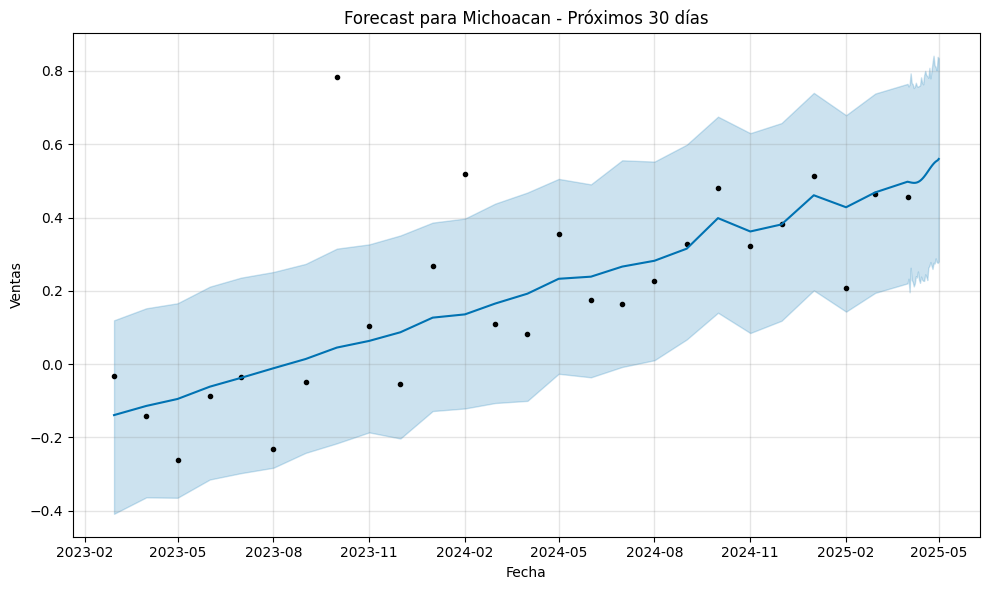

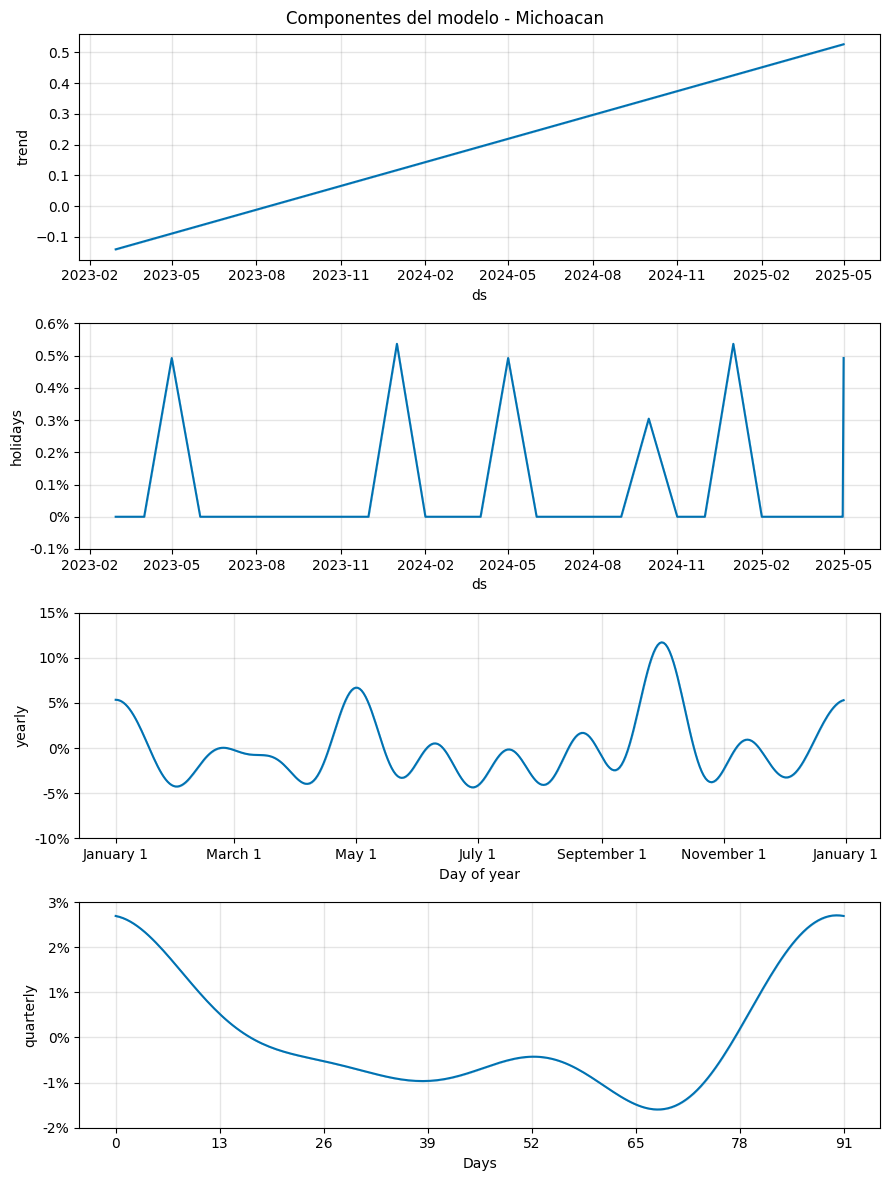

00:42:46 - cmdstanpy - INFO - Chain [1] start processing
00:42:46 - cmdstanpy - INFO - Chain [1] done processing
00:42:46 - cmdstanpy - INFO - Chain [1] start processing
00:42:46 - cmdstanpy - INFO - Chain [1] done processing
00:42:46 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.12', '0.07']
R² por fold: ['-0.092', '-1.617']
MAE por fold: ['0.26', '0.22']


00:42:48 - cmdstanpy - INFO - Chain [1] done processing


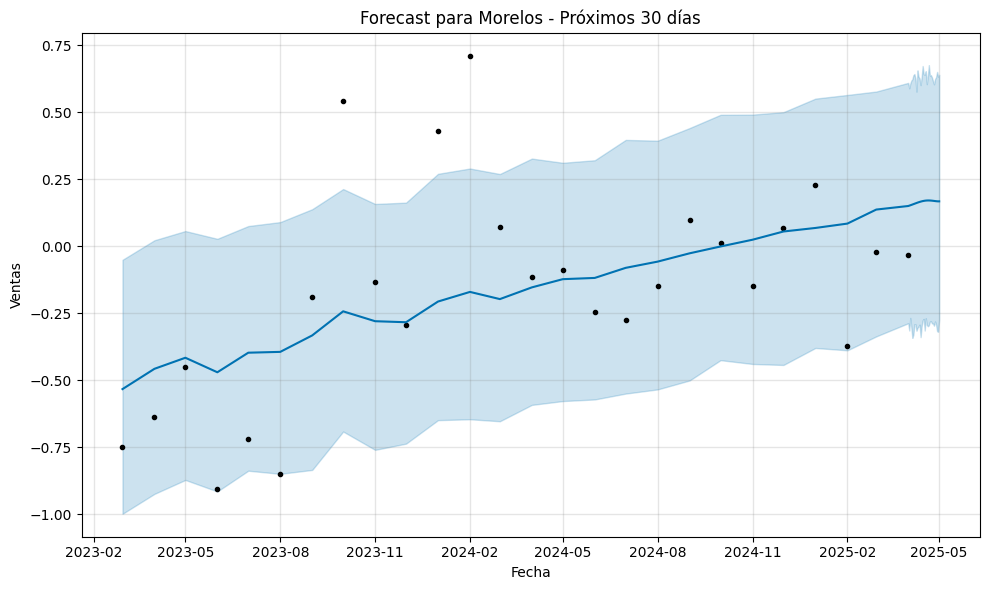

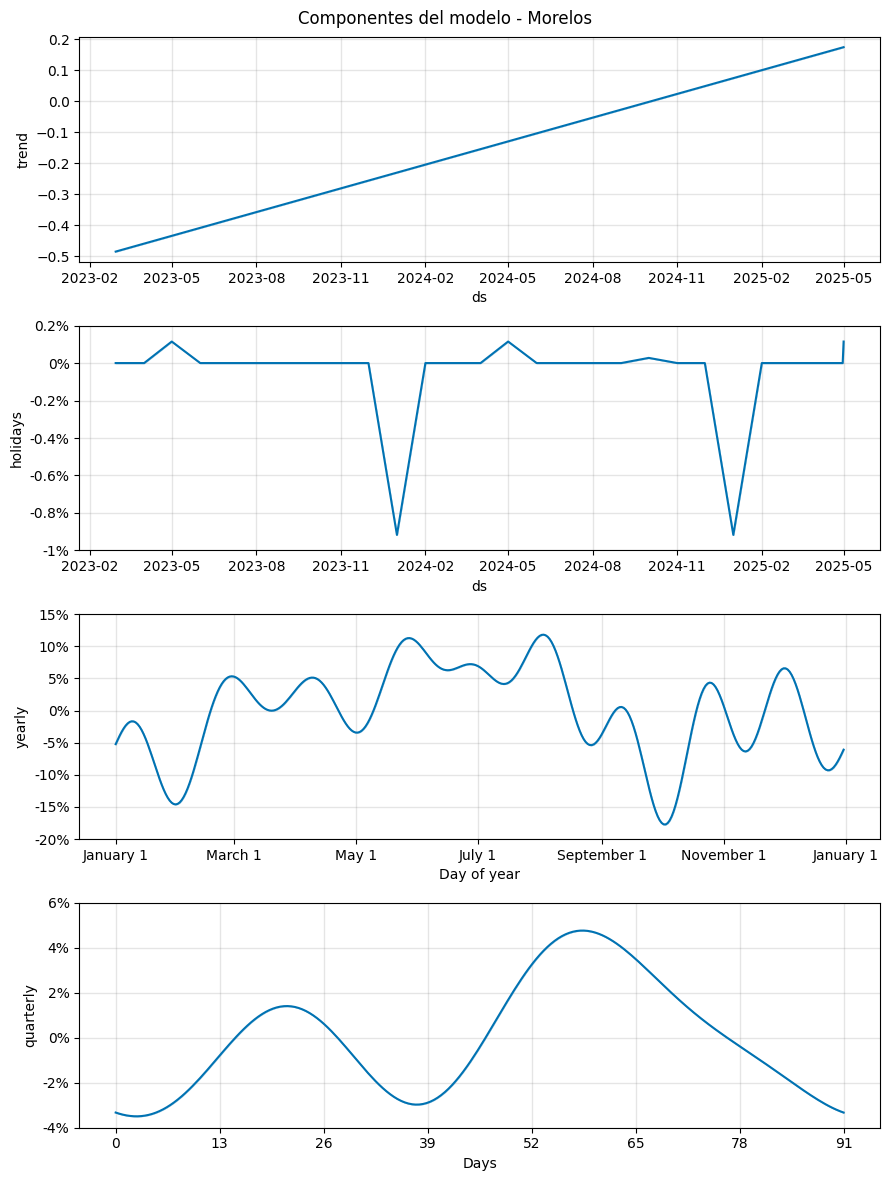

00:42:50 - cmdstanpy - INFO - Chain [1] start processing
00:42:51 - cmdstanpy - INFO - Chain [1] done processing
00:42:51 - cmdstanpy - INFO - Chain [1] start processing
00:42:51 - cmdstanpy - INFO - Chain [1] done processing
00:42:52 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.03', '0.04']
R² por fold: ['-0.199', '-0.936']
MAE por fold: ['0.15', '0.17']


00:42:53 - cmdstanpy - INFO - Chain [1] done processing


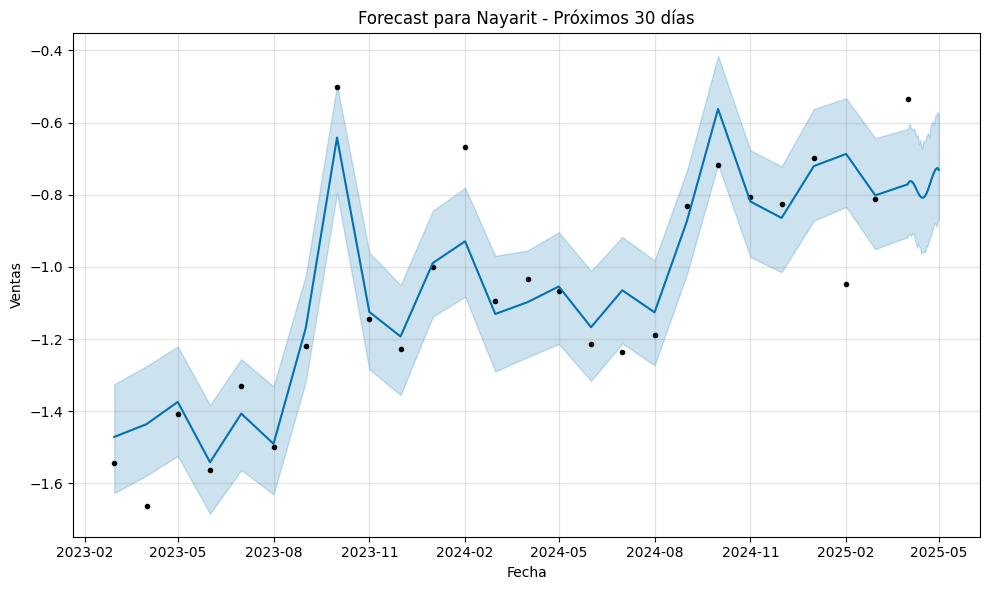

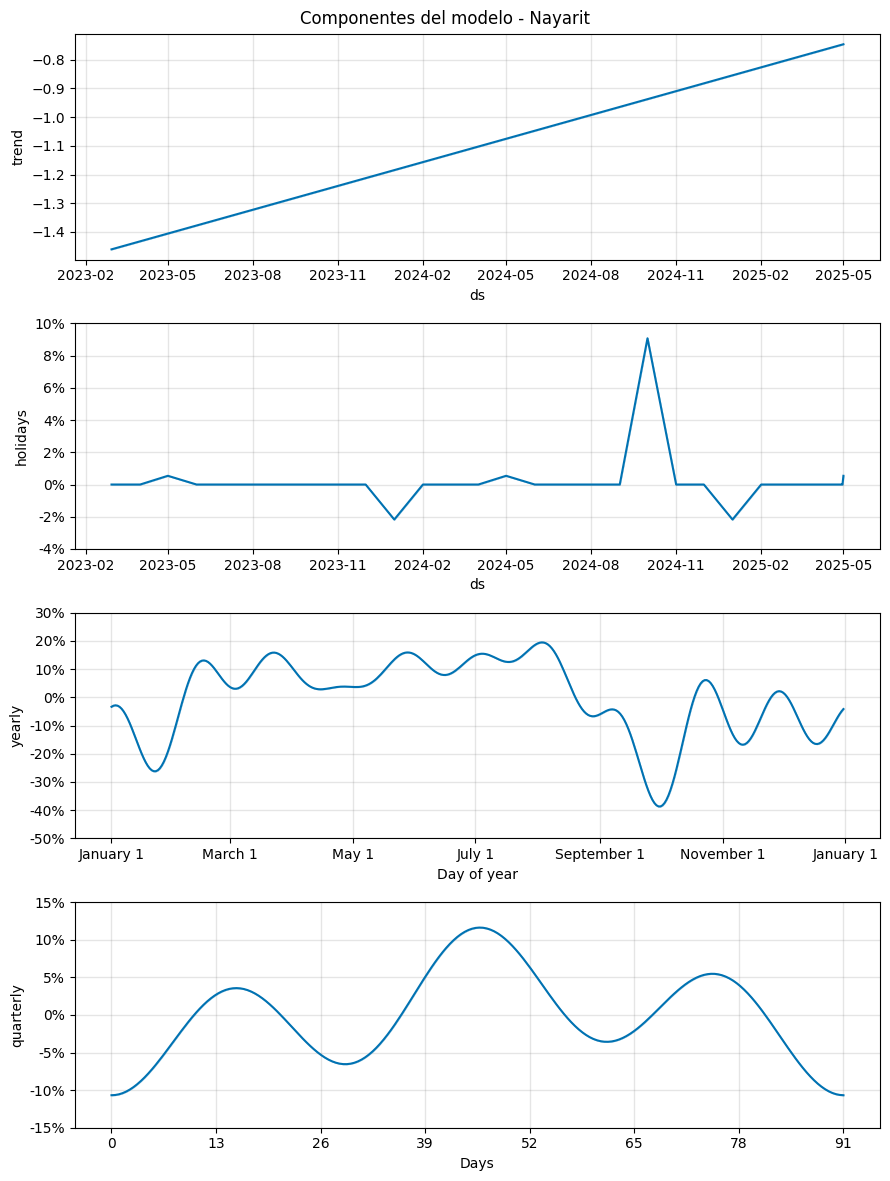

00:42:55 - cmdstanpy - INFO - Chain [1] start processing
00:42:55 - cmdstanpy - INFO - Chain [1] done processing
00:42:55 - cmdstanpy - INFO - Chain [1] start processing
00:42:56 - cmdstanpy - INFO - Chain [1] done processing
00:42:56 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.12', '0.02']
R² por fold: ['-17.405', '-0.366']
MAE por fold: ['0.33', '0.11']


00:42:56 - cmdstanpy - INFO - Chain [1] done processing


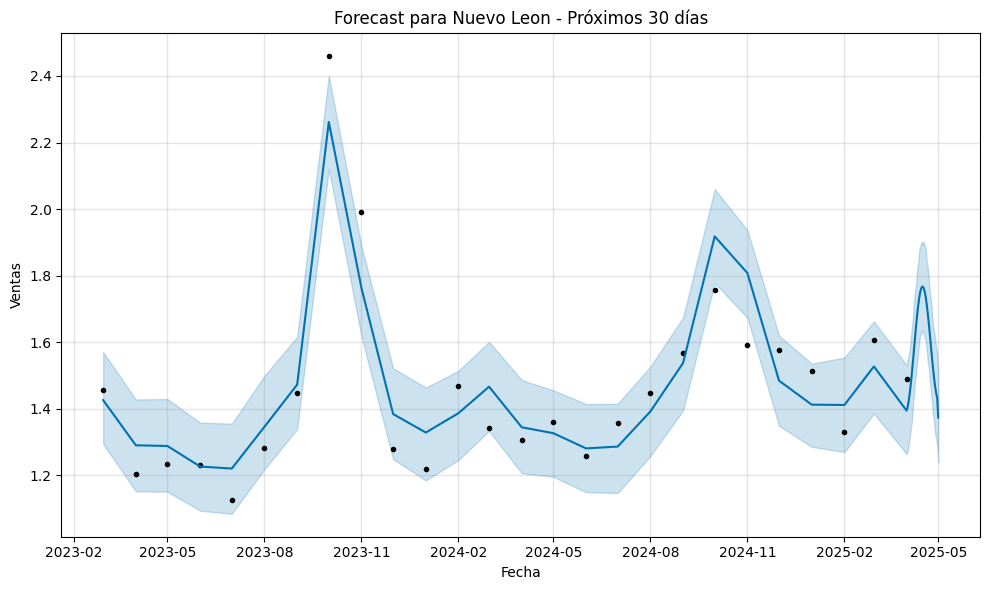

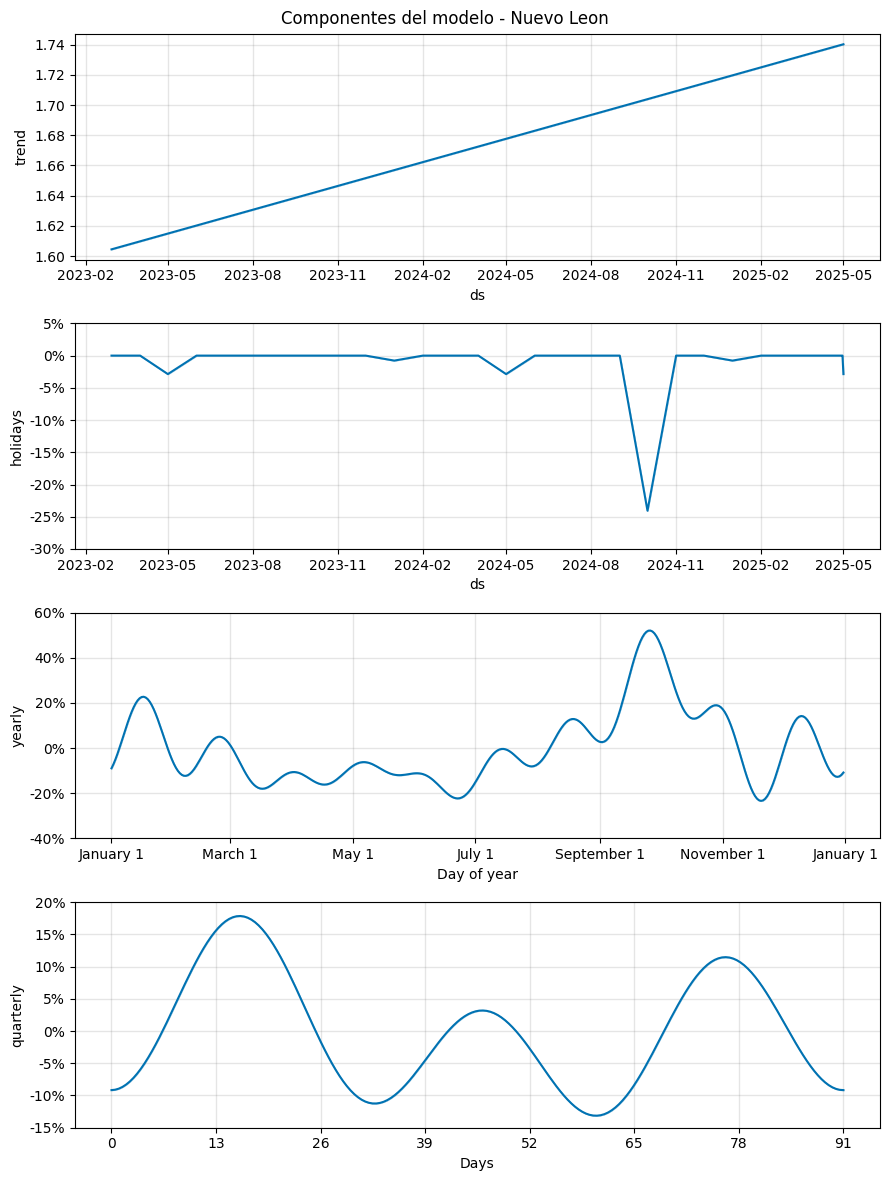

00:42:58 - cmdstanpy - INFO - Chain [1] start processing
00:42:58 - cmdstanpy - INFO - Chain [1] done processing
00:42:59 - cmdstanpy - INFO - Chain [1] start processing
00:42:59 - cmdstanpy - INFO - Chain [1] done processing
00:42:59 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.04', '0.02']
R² por fold: ['-0.272', '-0.159']
MAE por fold: ['0.14', '0.13']


00:42:59 - cmdstanpy - INFO - Chain [1] done processing


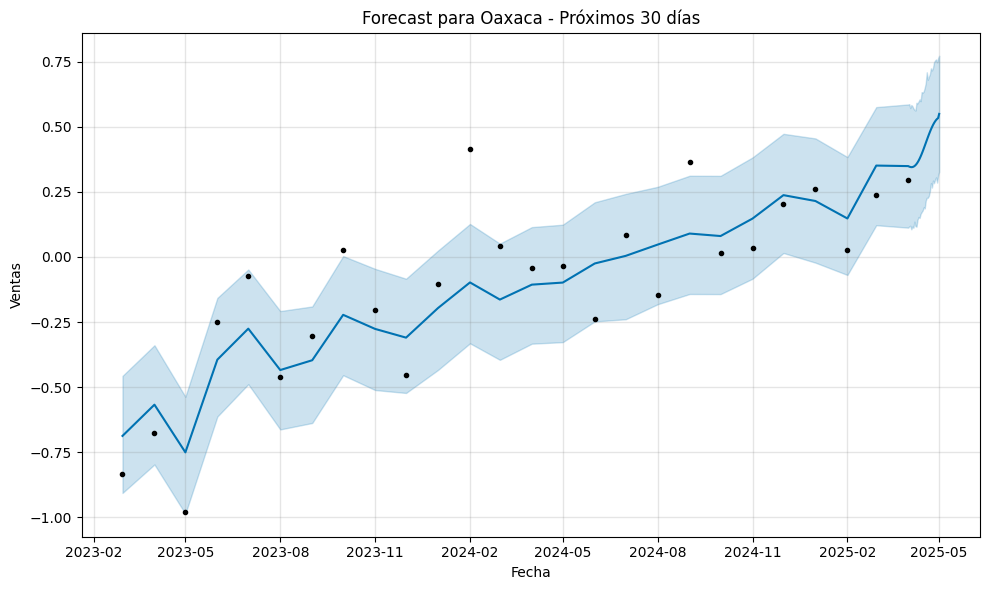

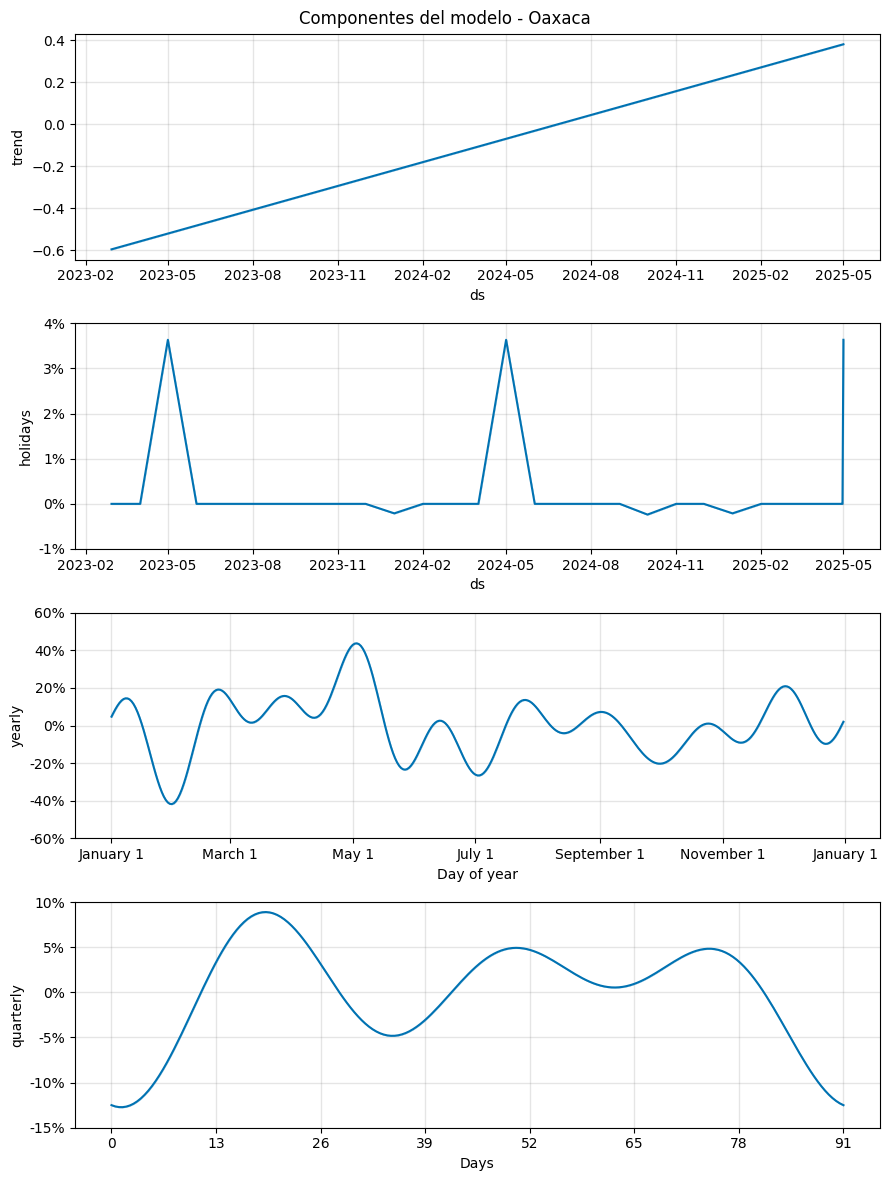

00:43:02 - cmdstanpy - INFO - Chain [1] start processing
00:43:02 - cmdstanpy - INFO - Chain [1] done processing
00:43:02 - cmdstanpy - INFO - Chain [1] start processing
00:43:02 - cmdstanpy - INFO - Chain [1] done processing
00:43:02 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.03', '0.02']
R² por fold: ['-0.442', '-0.262']
MAE por fold: ['0.13', '0.10']


00:43:03 - cmdstanpy - INFO - Chain [1] done processing


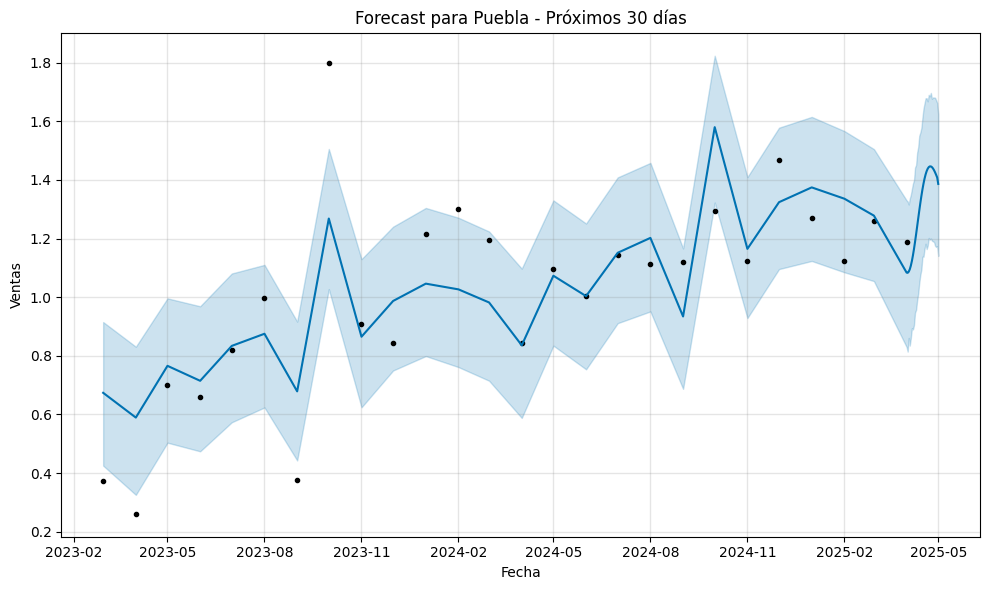

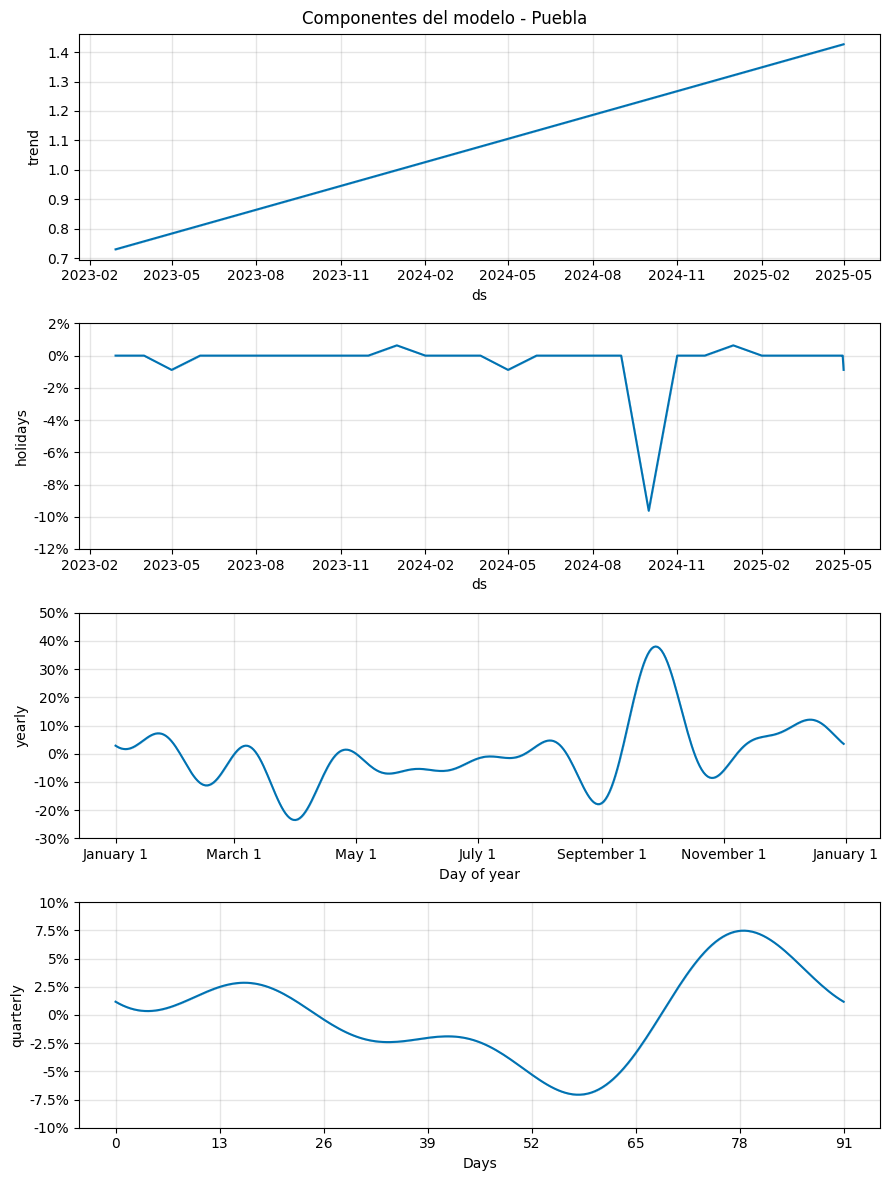

00:43:05 - cmdstanpy - INFO - Chain [1] start processing
00:43:06 - cmdstanpy - INFO - Chain [1] done processing
00:43:06 - cmdstanpy - INFO - Chain [1] start processing
00:43:06 - cmdstanpy - INFO - Chain [1] done processing
00:43:06 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.02', '0.04']
R² por fold: ['-0.283', '-4.707']
MAE por fold: ['0.14', '0.17']


00:43:08 - cmdstanpy - INFO - Chain [1] done processing


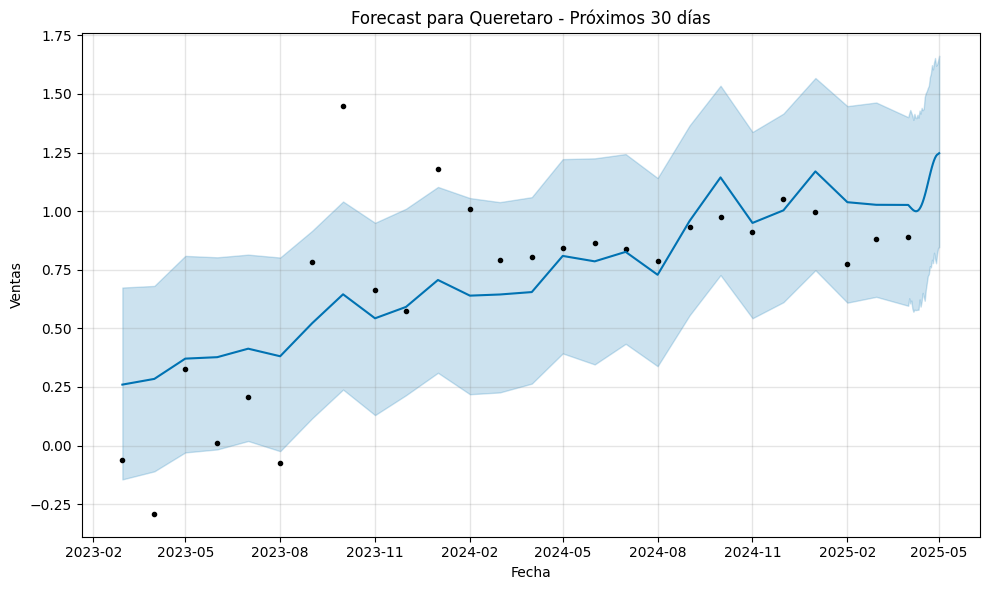

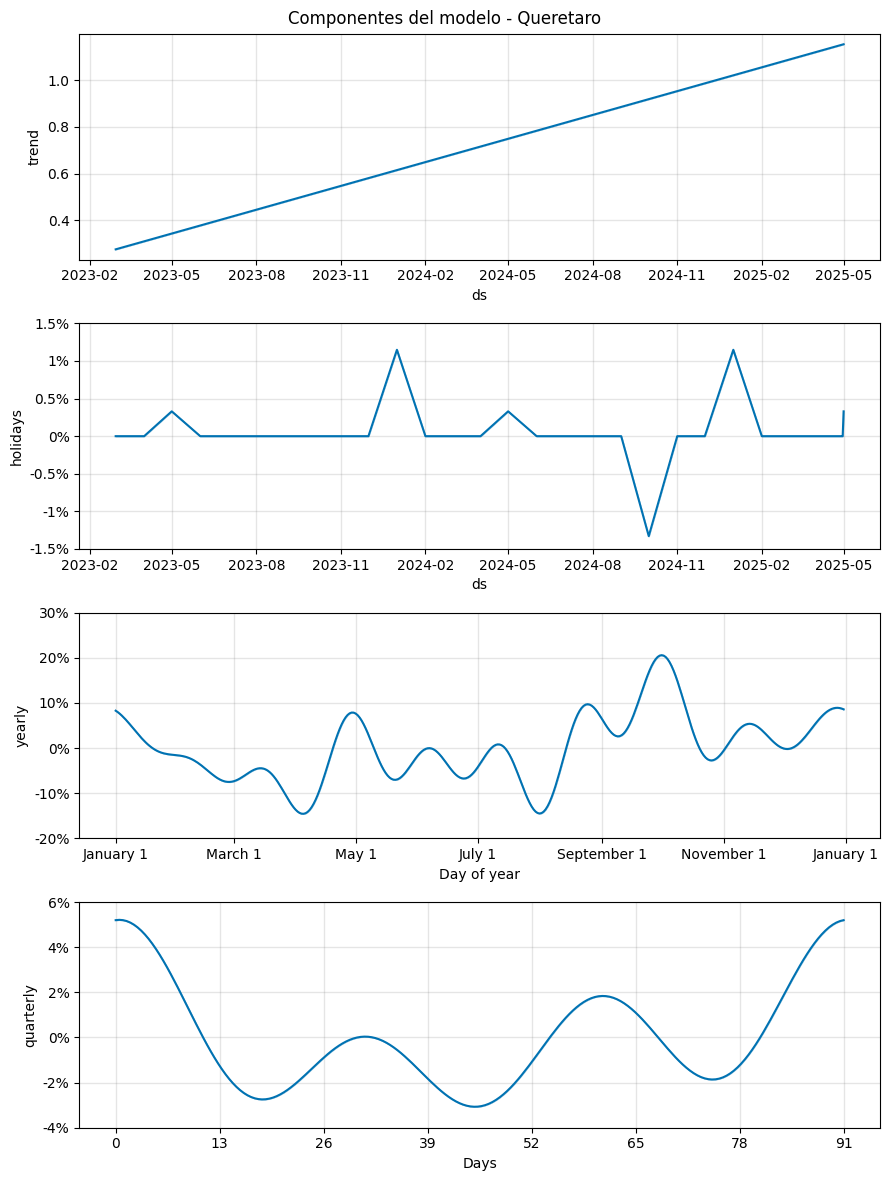

00:43:13 - cmdstanpy - INFO - Chain [1] start processing
00:43:13 - cmdstanpy - INFO - Chain [1] done processing
00:43:13 - cmdstanpy - INFO - Chain [1] start processing
00:43:13 - cmdstanpy - INFO - Chain [1] done processing
00:43:13 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.01', '0.02']
R² por fold: ['-0.777', '-0.018']
MAE por fold: ['0.07', '0.11']


00:43:14 - cmdstanpy - INFO - Chain [1] done processing


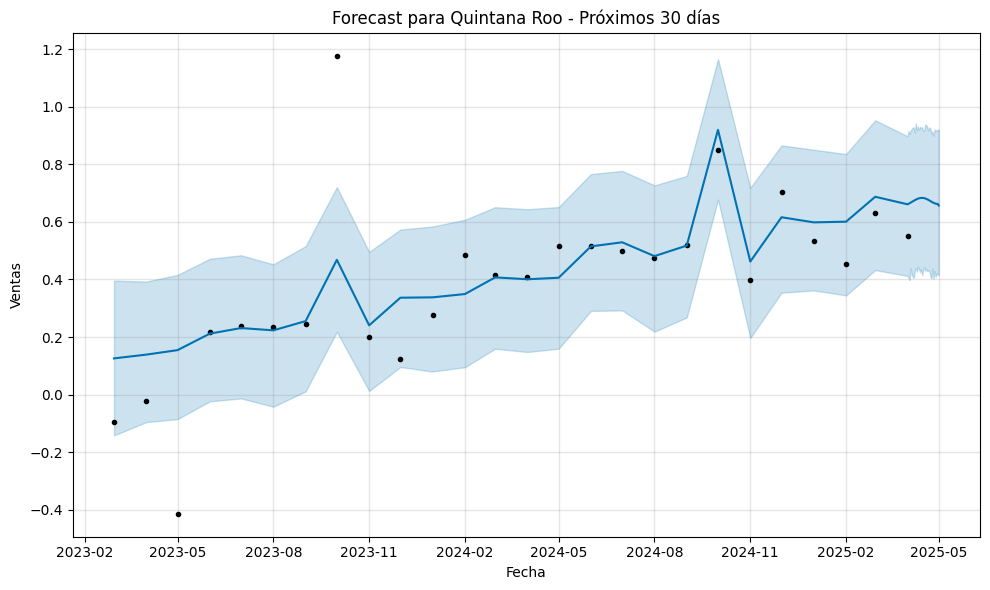

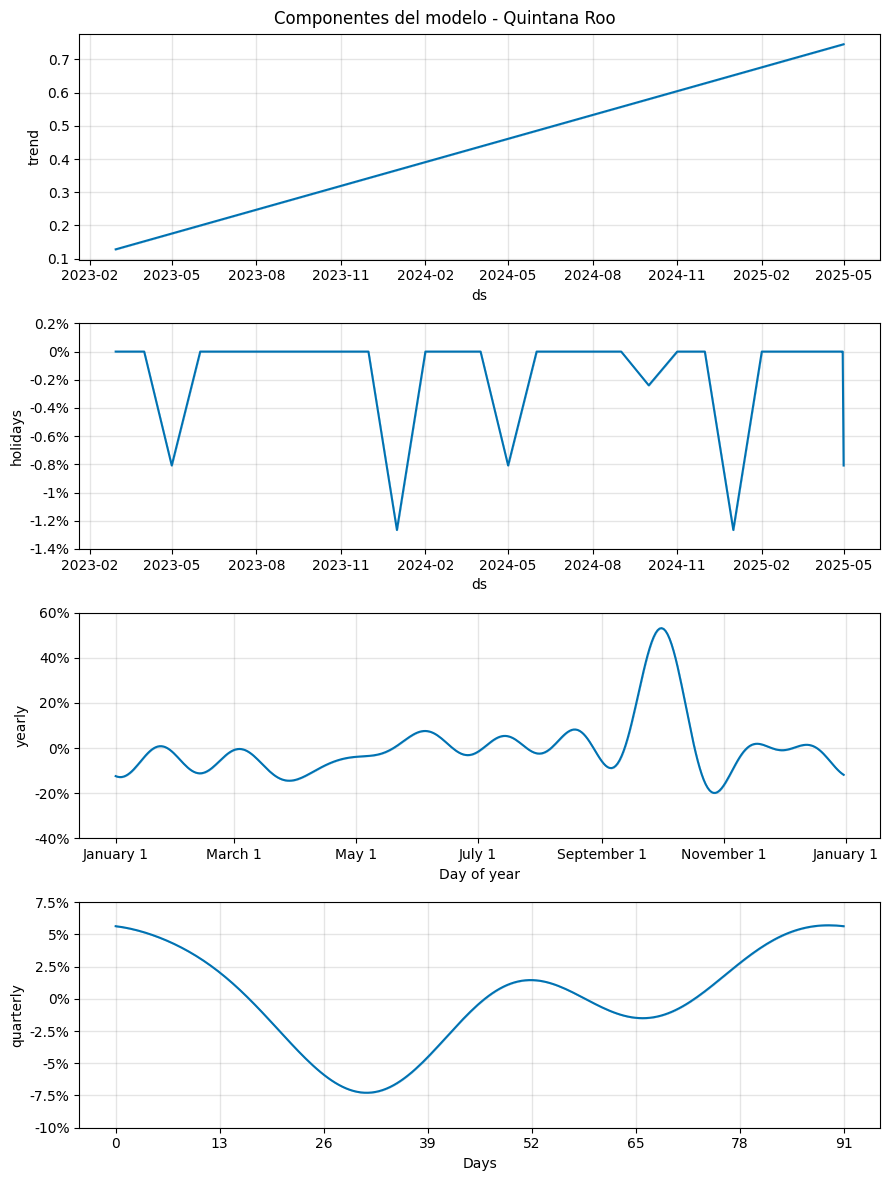

00:43:16 - cmdstanpy - INFO - Chain [1] start processing
00:43:16 - cmdstanpy - INFO - Chain [1] done processing
00:43:16 - cmdstanpy - INFO - Chain [1] start processing
00:43:16 - cmdstanpy - INFO - Chain [1] done processing
00:43:17 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.02', '0.02']
R² por fold: ['-1.080', '-0.560']
MAE por fold: ['0.10', '0.13']


00:43:17 - cmdstanpy - INFO - Chain [1] done processing


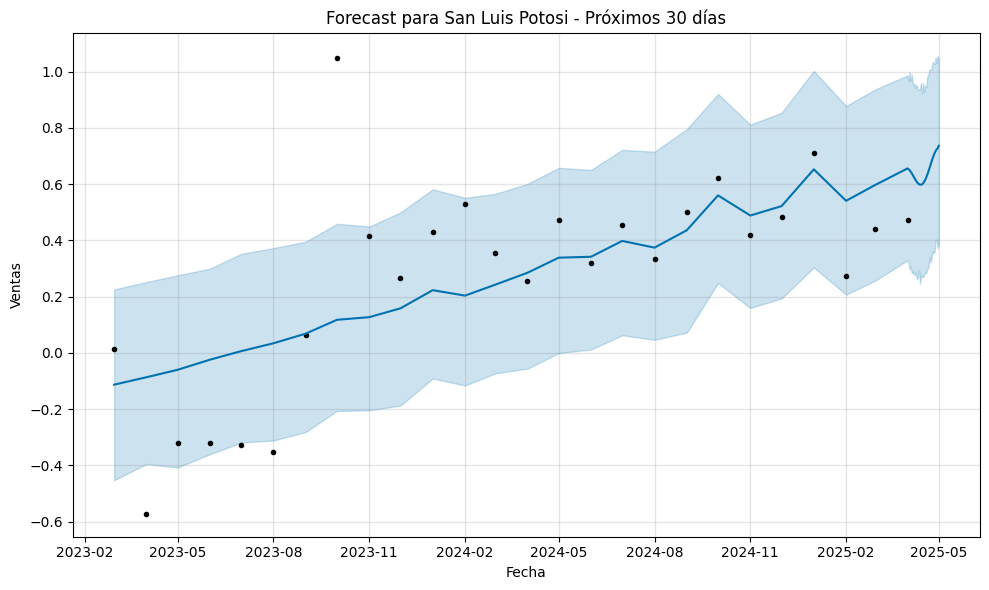

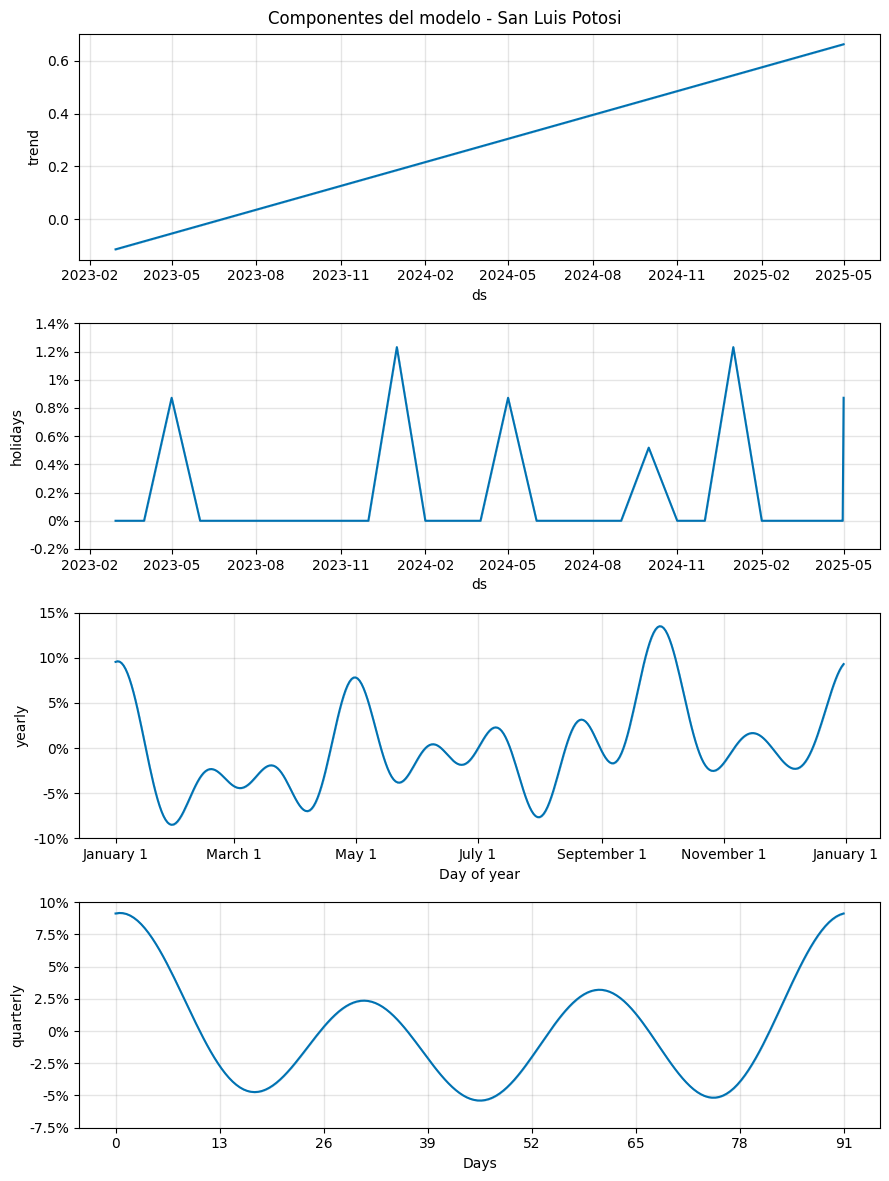

00:43:20 - cmdstanpy - INFO - Chain [1] start processing
00:43:20 - cmdstanpy - INFO - Chain [1] done processing
00:43:20 - cmdstanpy - INFO - Chain [1] start processing
00:43:20 - cmdstanpy - INFO - Chain [1] done processing
00:43:21 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.01', '0.02']
R² por fold: ['-0.767', '-1.988']
MAE por fold: ['0.07', '0.13']


00:43:21 - cmdstanpy - INFO - Chain [1] done processing


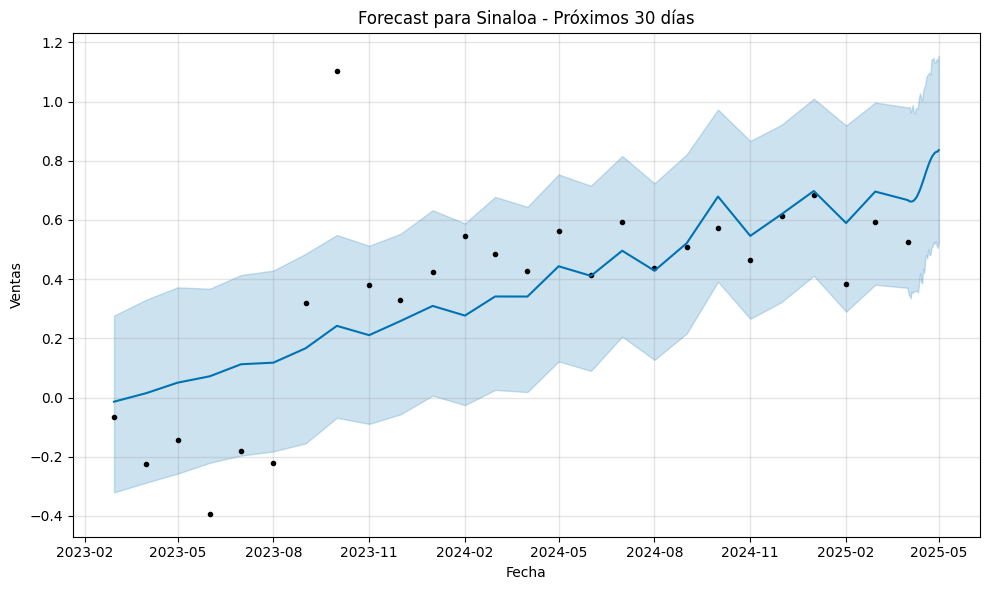

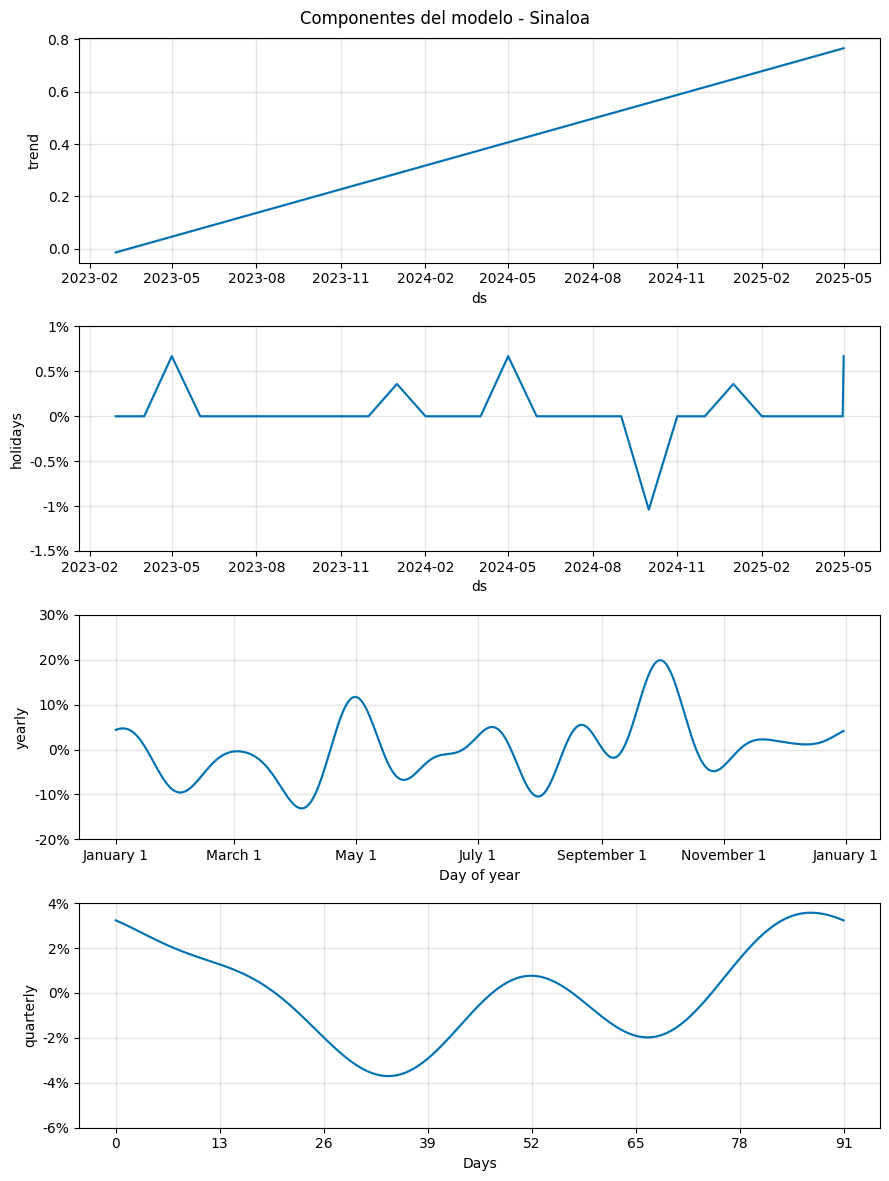

00:43:23 - cmdstanpy - INFO - Chain [1] start processing
00:43:23 - cmdstanpy - INFO - Chain [1] done processing
00:43:23 - cmdstanpy - INFO - Chain [1] start processing
00:43:23 - cmdstanpy - INFO - Chain [1] done processing
00:43:24 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.02', '0.01']
R² por fold: ['-0.995', '-3.726']
MAE por fold: ['0.12', '0.09']


00:43:34 - cmdstanpy - INFO - Chain [1] done processing


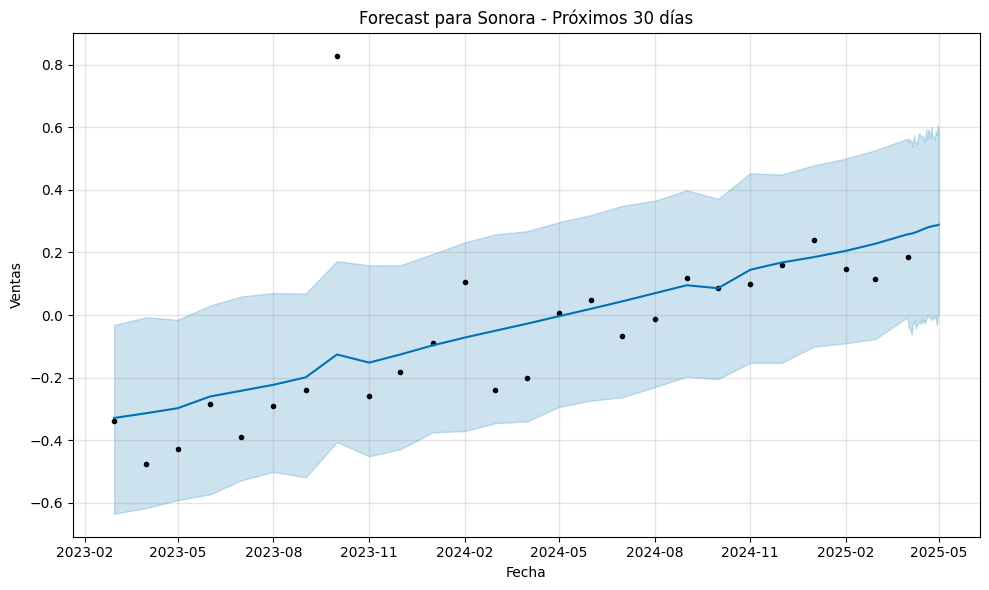

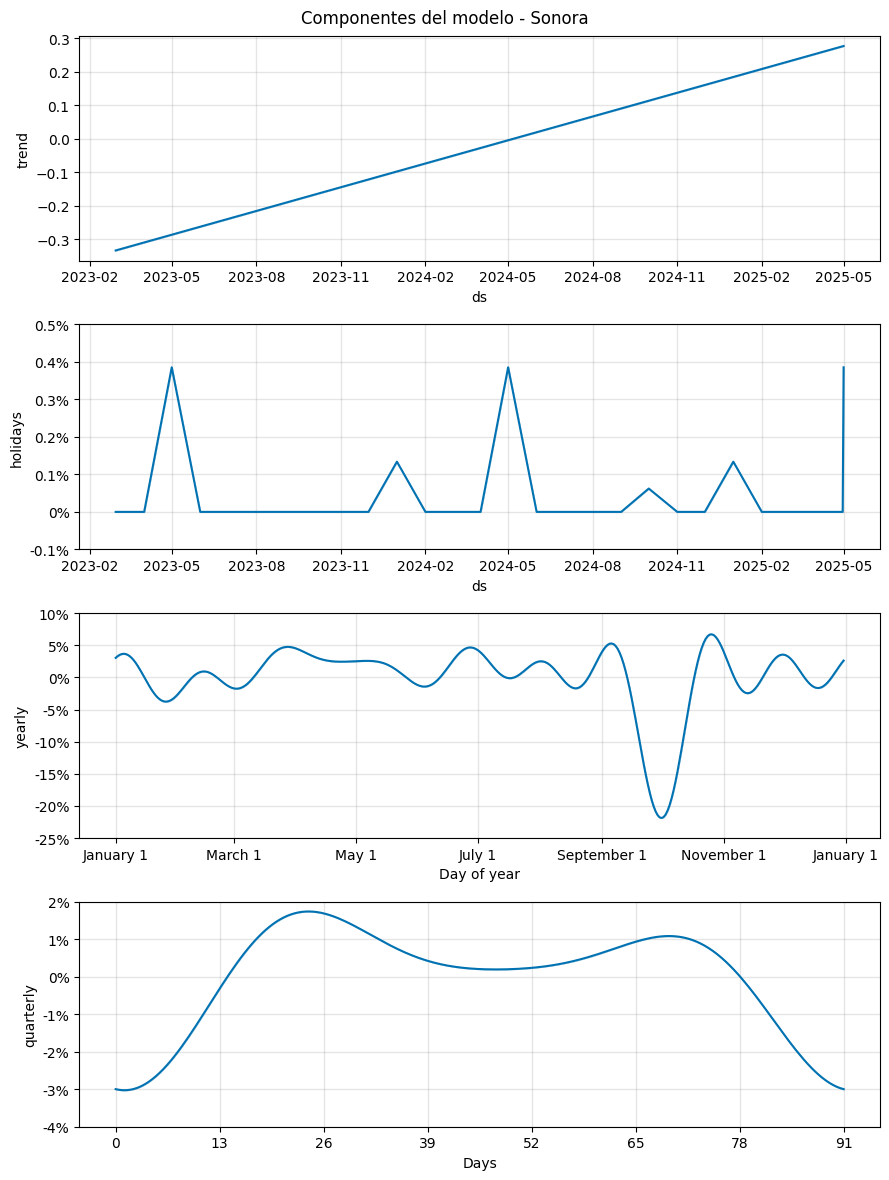

00:43:36 - cmdstanpy - INFO - Chain [1] start processing
00:43:36 - cmdstanpy - INFO - Chain [1] done processing
00:43:37 - cmdstanpy - INFO - Chain [1] start processing
00:43:37 - cmdstanpy - INFO - Chain [1] done processing
00:43:37 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.10', '0.02']
R² por fold: ['-1.016', '-0.265']
MAE por fold: ['0.22', '0.12']


00:43:37 - cmdstanpy - INFO - Chain [1] done processing


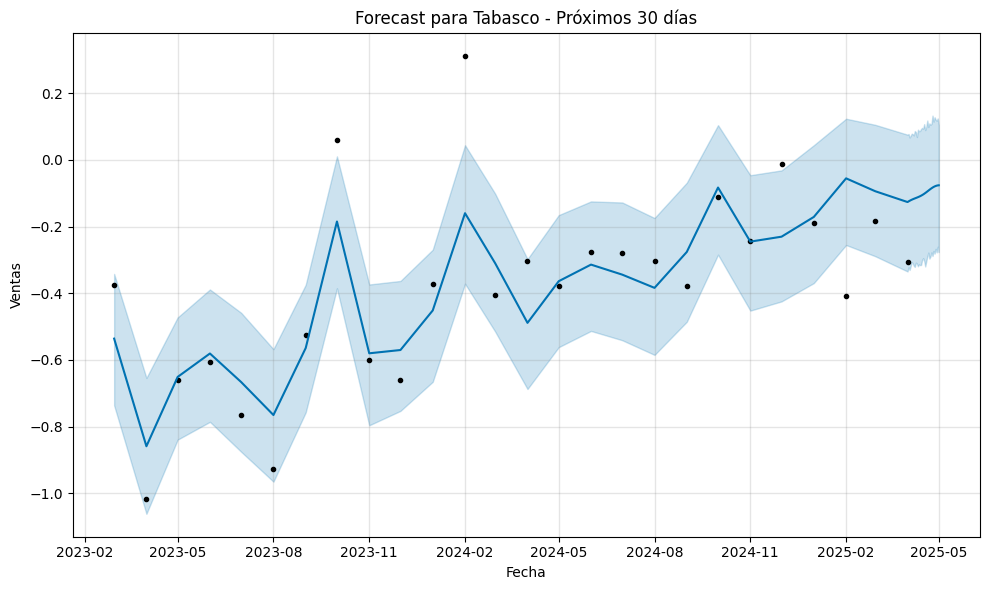

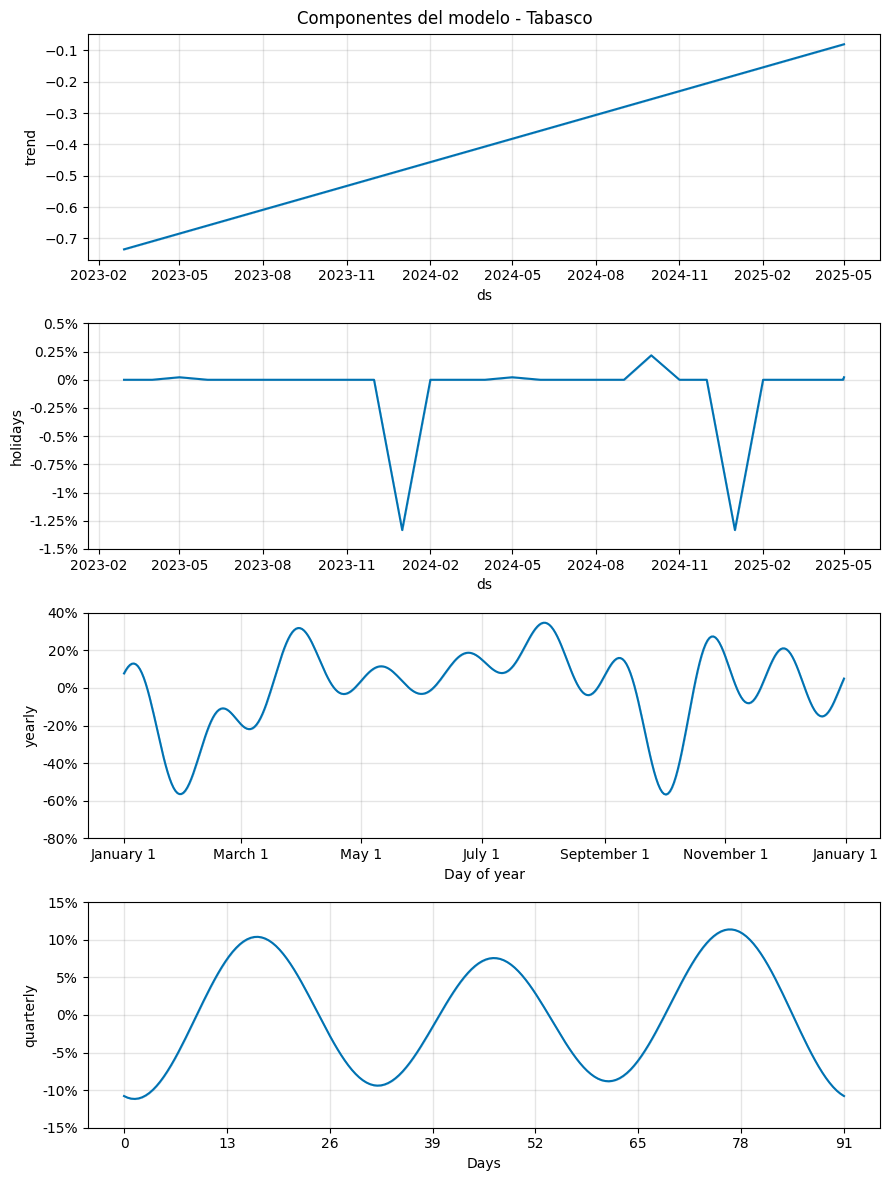

00:43:40 - cmdstanpy - INFO - Chain [1] start processing
00:43:40 - cmdstanpy - INFO - Chain [1] done processing
00:43:40 - cmdstanpy - INFO - Chain [1] start processing
00:43:40 - cmdstanpy - INFO - Chain [1] done processing
00:43:40 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.01', '0.02']
R² por fold: ['-0.645', '-3.461']
MAE por fold: ['0.09', '0.12']


00:43:41 - cmdstanpy - INFO - Chain [1] done processing


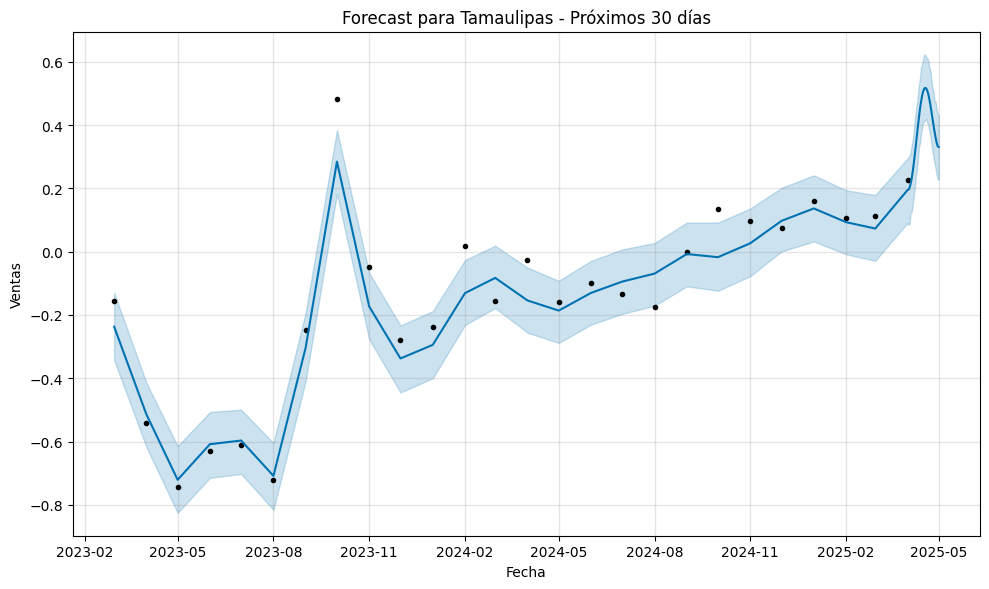

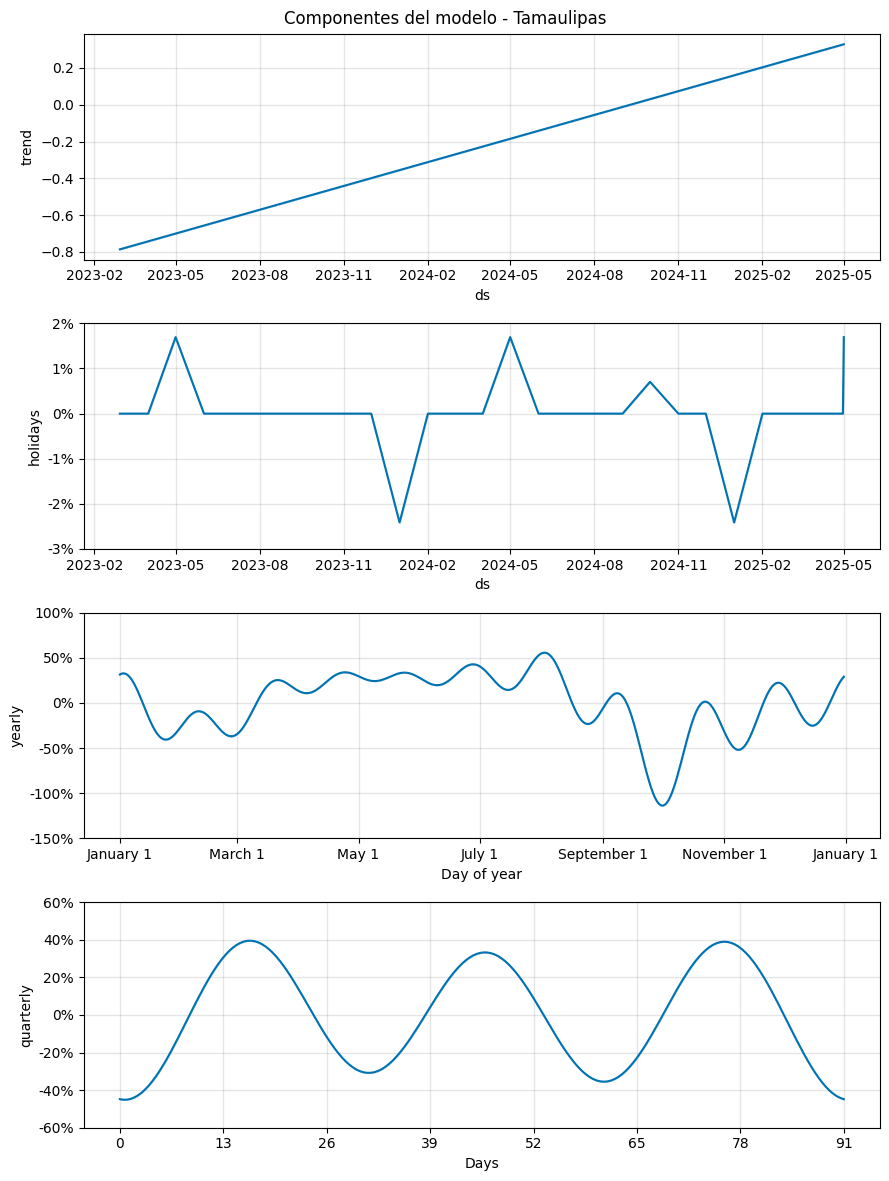

00:43:43 - cmdstanpy - INFO - Chain [1] start processing
00:43:44 - cmdstanpy - INFO - Chain [1] done processing
00:43:44 - cmdstanpy - INFO - Chain [1] start processing
00:43:44 - cmdstanpy - INFO - Chain [1] done processing
00:43:46 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.13', '0.06']
R² por fold: ['-0.048', '0.039']
MAE por fold: ['0.29', '0.17']


00:43:46 - cmdstanpy - INFO - Chain [1] done processing


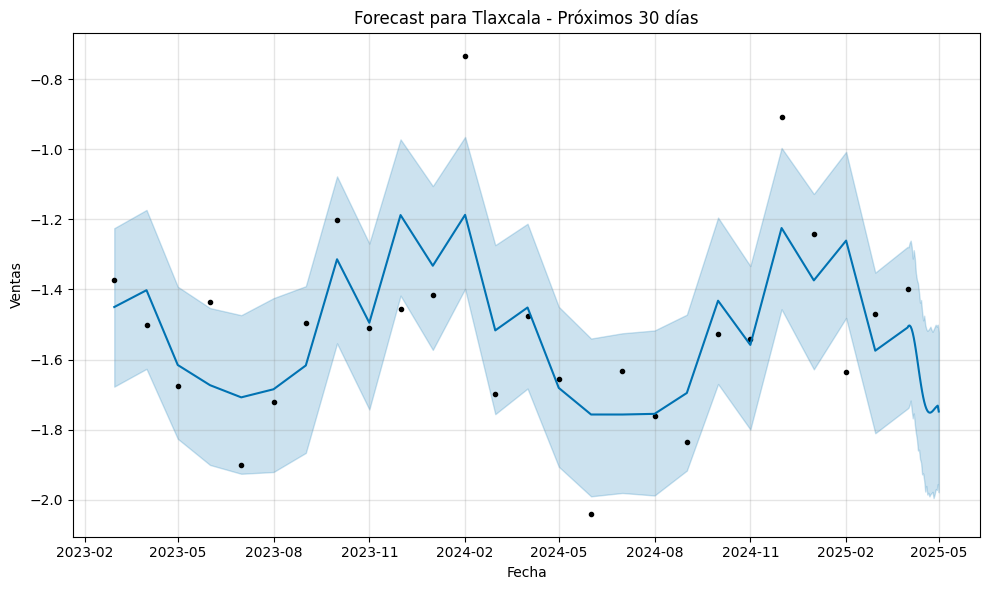

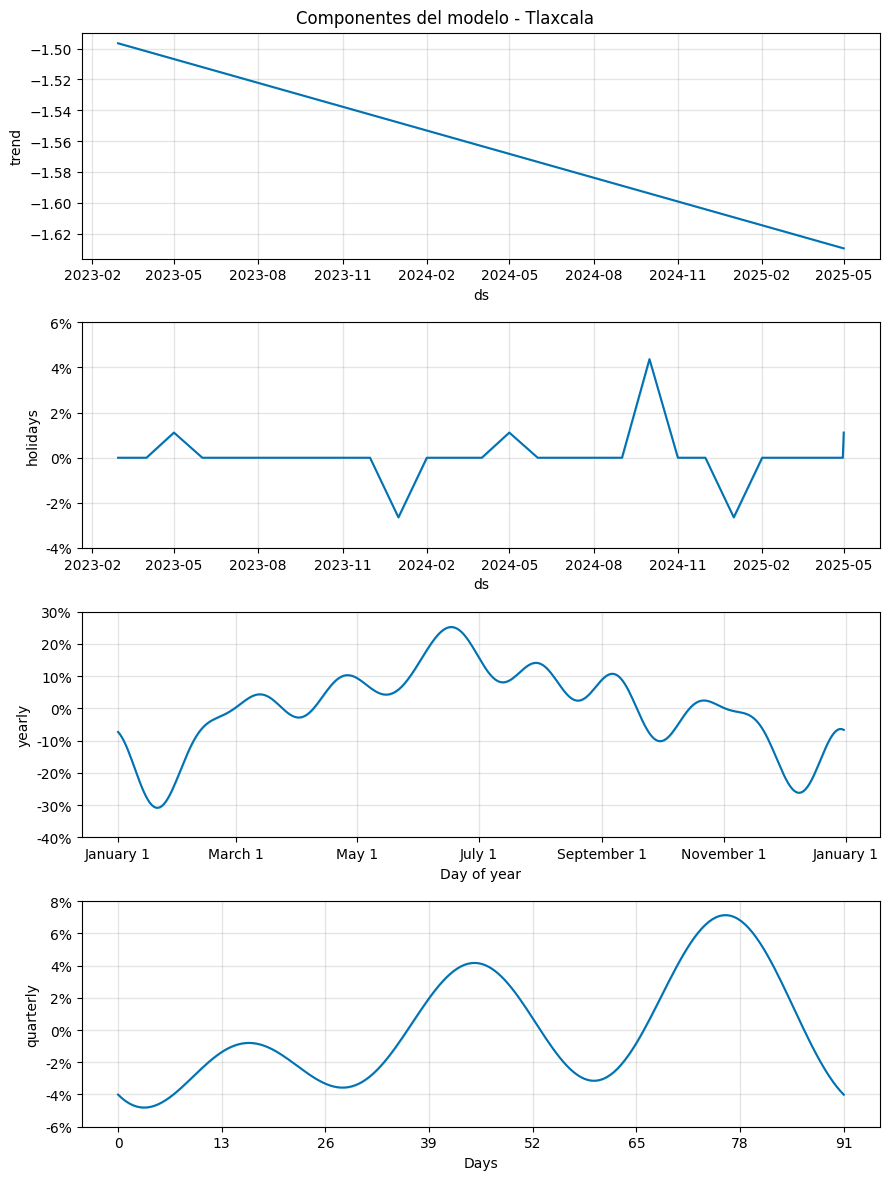

00:43:49 - cmdstanpy - INFO - Chain [1] start processing
00:43:52 - cmdstanpy - INFO - Chain [1] done processing
00:43:53 - cmdstanpy - INFO - Chain [1] start processing
00:43:53 - cmdstanpy - INFO - Chain [1] done processing
00:43:53 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.07', '0.05']
R² por fold: ['-0.894', '-1.517']
MAE por fold: ['0.25', '0.18']


00:43:53 - cmdstanpy - INFO - Chain [1] done processing


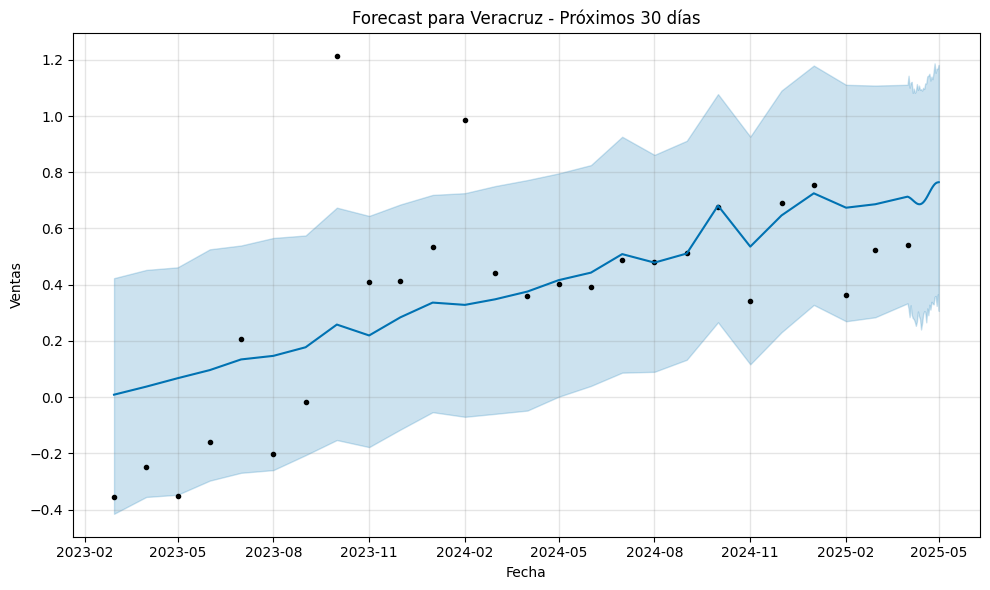

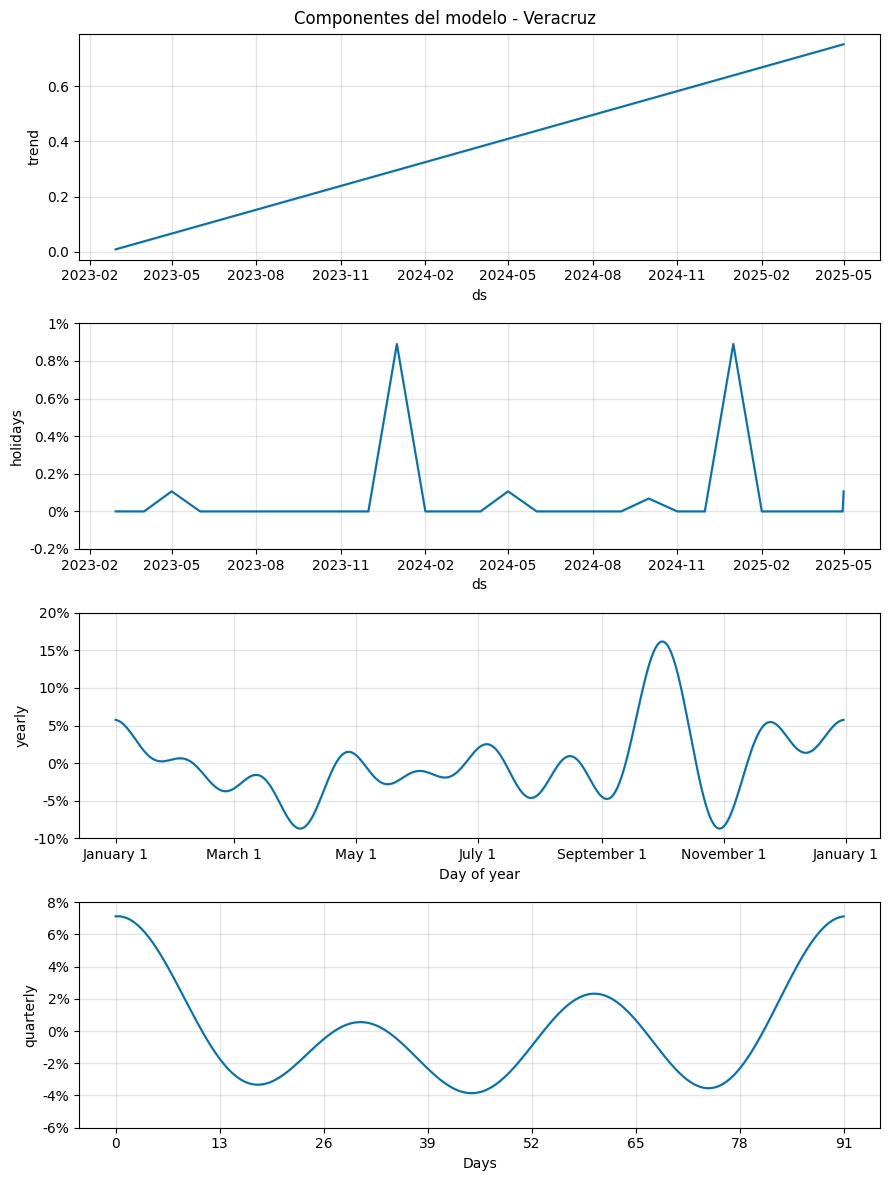

00:43:56 - cmdstanpy - INFO - Chain [1] start processing
00:43:56 - cmdstanpy - INFO - Chain [1] done processing
00:43:57 - cmdstanpy - INFO - Chain [1] start processing
00:43:57 - cmdstanpy - INFO - Chain [1] done processing
00:43:57 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.02', '0.05']
R² por fold: ['-0.036', '-1.470']
MAE por fold: ['0.12', '0.20']


00:44:00 - cmdstanpy - INFO - Chain [1] done processing


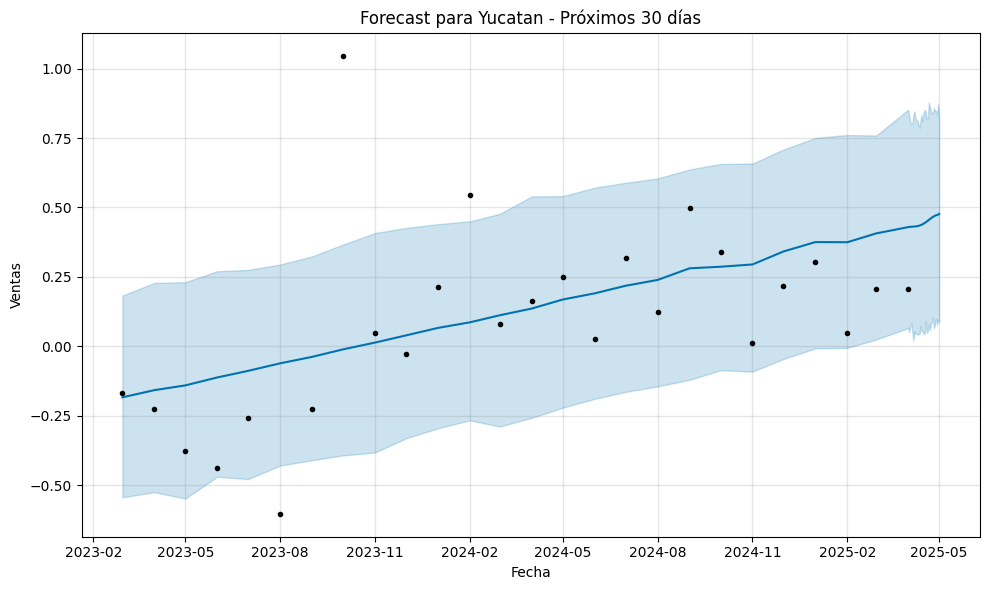

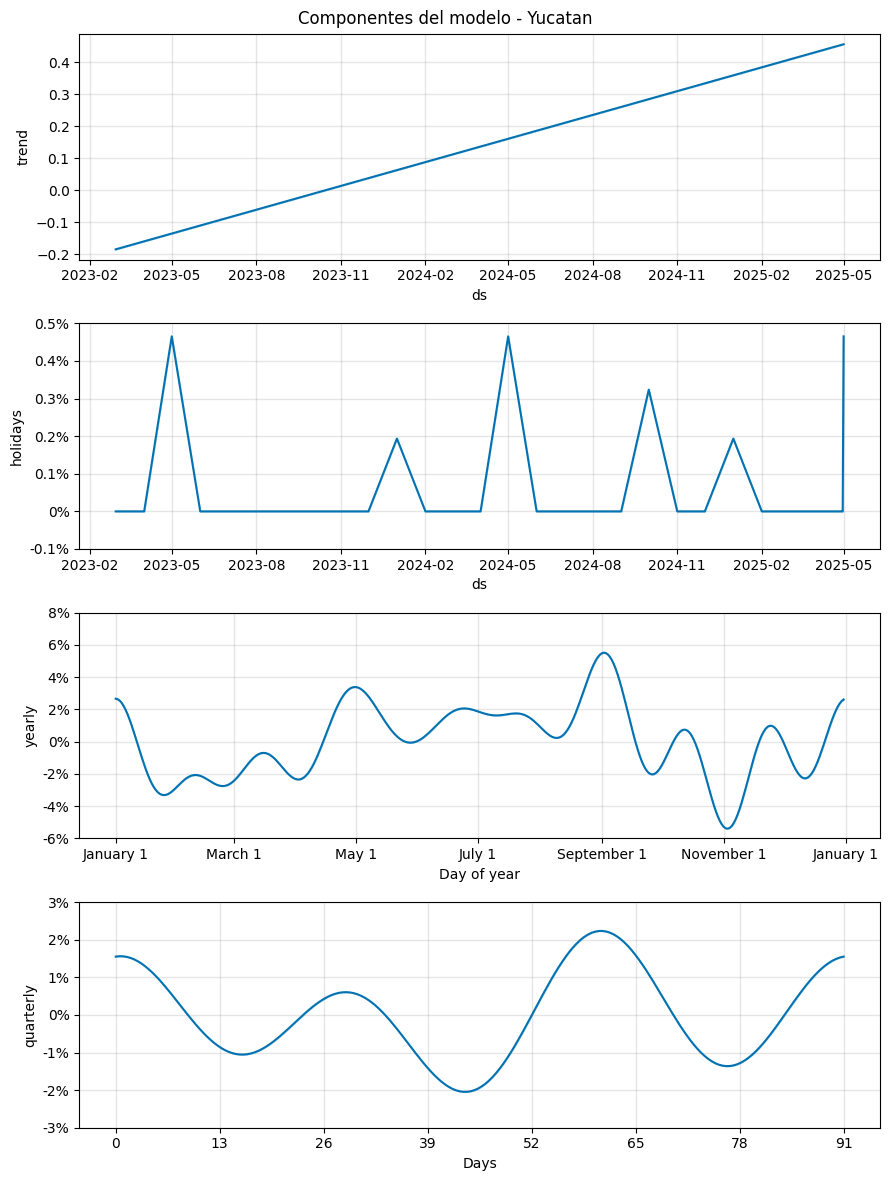

00:44:03 - cmdstanpy - INFO - Chain [1] start processing
00:44:03 - cmdstanpy - INFO - Chain [1] done processing
00:44:03 - cmdstanpy - INFO - Chain [1] start processing
00:44:03 - cmdstanpy - INFO - Chain [1] done processing
00:44:03 - cmdstanpy - INFO - Chain [1] start processing


MSE por fold: ['0.05', '0.02']
R² por fold: ['-0.089', '-0.097']
MAE por fold: ['0.20', '0.11']


00:44:05 - cmdstanpy - INFO - Chain [1] done processing


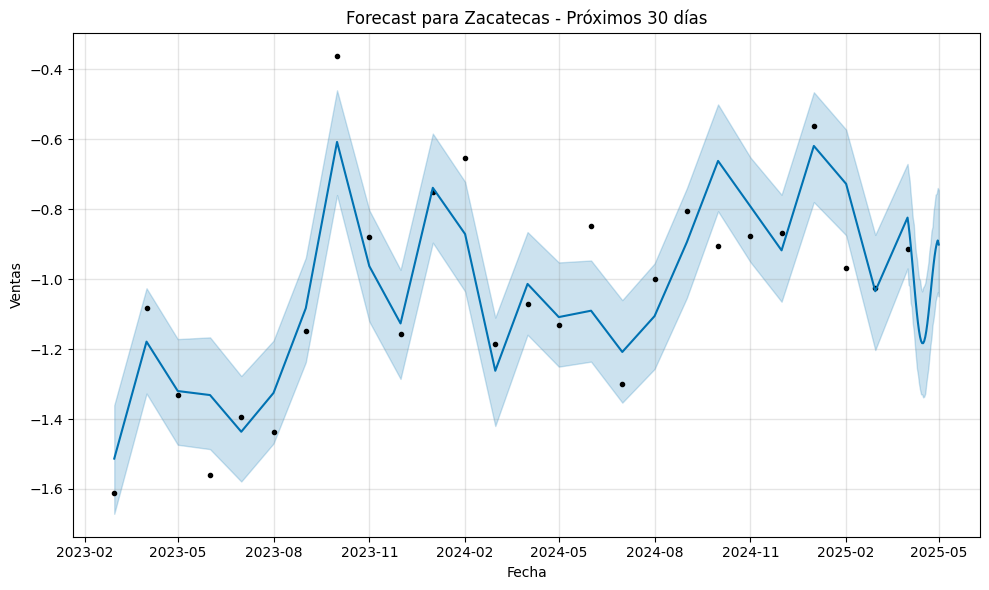

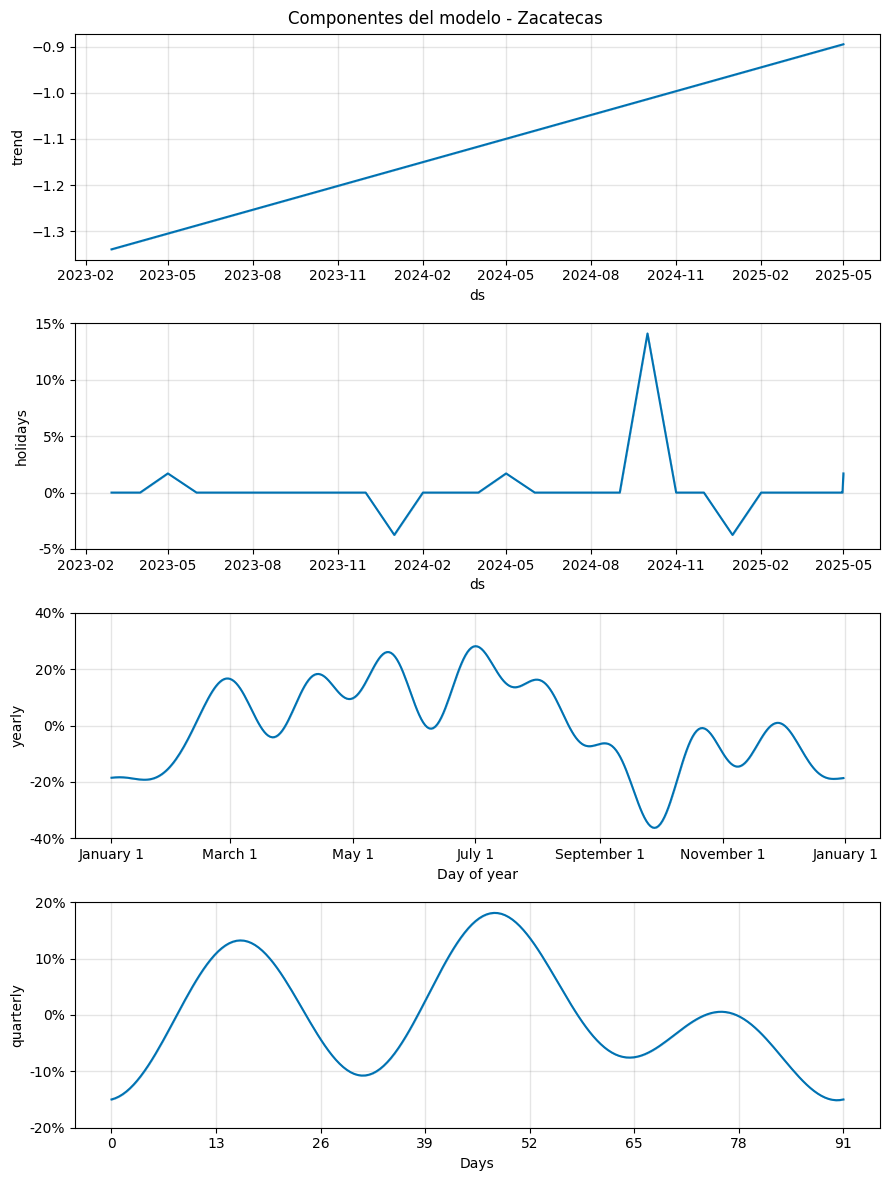

In [31]:
for edo in edos:
    df_edo = df1[df1['Estado'] == edo]
    ml_df = df_edo[['Fecha', 'Ventas']].rename(columns={'Fecha': 'ds', 'Ventas': 'y'})

    
    # Cross-validation
    cv_results = []
    tscv = TimeSeriesSplit(n_splits=2)  
    for fold, (train_index, test_index) in enumerate(tscv.split(ml_df)):
        train = ml_df.iloc[train_index]
        test = ml_df.iloc[test_index]
        
        model_cv = Prophet(**model_config)
        model_cv.add_country_holidays(country_name='Mexico')
        model_cv.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
        
        model_cv.fit(train)
        future = model_cv.make_future_dataframe(periods=len(test))
        forecast = model_cv.predict(future)
        
        # Métricas
        y_true = test['y'].values
        y_pred = forecast['yhat'][-len(test):].values
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)


        cv_results.append({
            'estado': edo,
            'fold': fold, 
            'mse': mse, 
            'r2': r2, 
            'mae': mae
        })
    
    # resultados del Ts split
    avg_mse = np.mean([r['mse'] for r in cv_results])
    avg_r2 = np.mean([r['r2'] for r in cv_results])
    avg_mae = np.mean([r['mae'] for r in cv_results])
    
    # Métricas por fold
    print("MSE por fold:", [f"{r['mse']:.2f}" for r in cv_results])
    print("R² por fold:", [f"{r['r2']:.3f}" for r in cv_results])
    print("MAE por fold:", [f"{r['mae']:.2f}" for r in cv_results])
    
    # Modelo final 

    model_final = Prophet(**model_config)
    model_final.add_country_holidays(country_name='Mexico')
    model_final.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
    model_final.fit(ml_df)
    with open(f'{edo}_prophet_model.pkl', 'wb') as f:
        pickle.dump(model_final, f)
    cv_df = pd.DataFrame(cv_results)
    cv_df.to_csv(f'{edo}_cv_results.csv', index=False)

    future = model_final.make_future_dataframe(periods=30)
    forecast = model_final.predict(future)
    
    # Gráfica mejorada
    fig = model_final.plot(forecast)
    plt.title(f'Forecast para {edo} - Próximos 30 días')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.tight_layout()
    plt.show()
    
    # Componentes del modelo
    fig2 = model_final.plot_components(forecast)
    plt.suptitle(f'Componentes del modelo - {edo}')
    plt.tight_layout()
    plt.show()

### Model Fitting Pytorch LSTM